# Admixture simple calibration

## Setup

In [1]:
library(tidyverse)
library(wesanderson)
library(gridExtra)
library(ggforce)
library(qqplotr)
library(svglite)
library(GGally)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘qqplotr’


The following objects are masked from ‘package:ggplot2’:

    stat_qq_line, StatQqLine


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:
pal <- wes_palettes$"BottleRocket2"
colors <- pal[1:4]
popcolors <- c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33')

### Useful functions

In [3]:
wrap_by <- function(...) {
  facet_wrap(vars(...), labeller = label_both)
}
plotFrequencies <- function(df, scoef, mcoef){
    df %>% 
        filter(s==scoef&m==mcoef) %>%
        ggplot(aes(x=generation, y=freq, color = pop) ) +
        geom_point(size=0.1, alpha = 0.01 ) +
        facet_wrap(~pop, ncol=1, strip.position="right") +
        ylim(c(0,1)) +
        theme_light() +
        theme(legend.position = "none") +
        labs(subtitle = paste0("m=",mcoef)) +
        scale_color_manual(values=popcolors)
    
}


### Read data

In [4]:
hapflk <- read_delim("simple.tab.gz", delim = " ")


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  chr = col_double(),
  pos = col_double(),
  flk = col_double(),
  replicate = col_double(),
  covariance = col_character(),
  hapflk = col_double(),
  m = col_double(),
  s = col_double()
)




In [5]:
hapflk$s <- factor(hapflk$s)
hapflk$m <- factor(hapflk$m)

In [6]:
frequencies <- read_delim("frequencies_simple.tsv.gz", delim = " ") %>% filter(pop!="index")
frequencies$s <- factor(frequencies$s)
frequencies$m <- factor(frequencies$m)


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  generation = col_double(),
  pop = col_character(),
  freq = col_double(),
  s = col_double(),
  m = col_double(),
  rep = col_double()
)




In [7]:
K <- 10
n_pop <- 3

In [8]:
flk_df <- n_pop-1

In [9]:
hapflk_df <- (n_pop -1) *(K -1)

## Data summaries

In [30]:
max_gen <- frequencies %>% pull(generation) %>% max()
max_gen

[1] 5700

Hay algunas simulaciones que perdieron m2 en p4, asi que filtro sólo aquellas que no se perdieron.

In [31]:
out_reps <- frequencies %>% 
            filter(generation==max_gen) %>%
            filter(s==0.1&pop=="p4"&freq < 0.5) %>% 
            select(rep,s,m) %>% distinct()

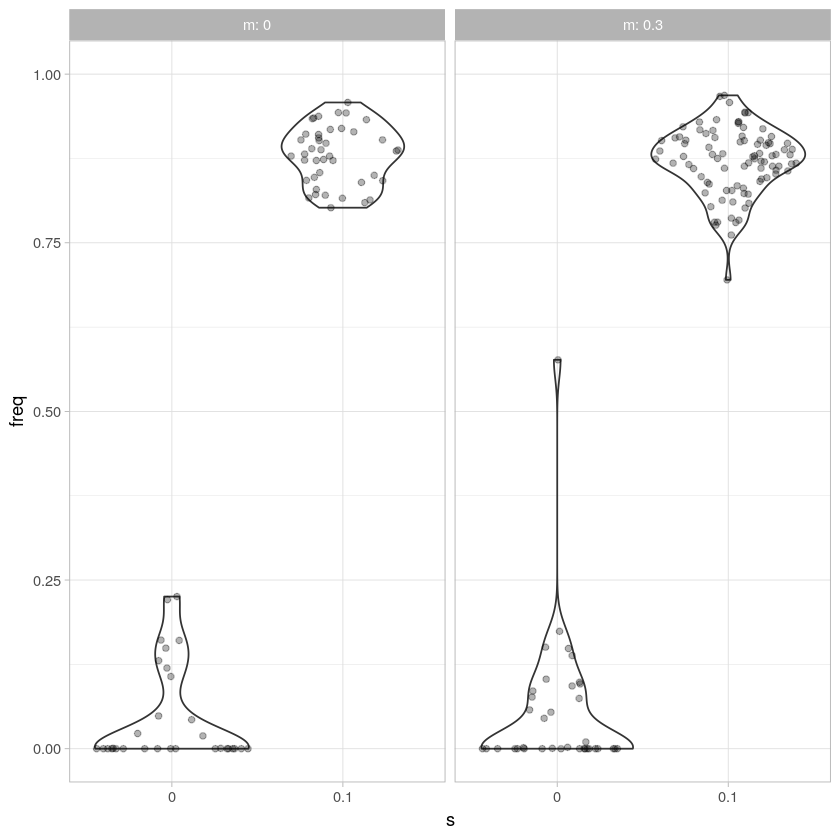

In [32]:
anti_join(frequencies, out_reps, by=c("rep","s","m")) %>%
        filter(generation==max_gen) %>%
        filter(pop=="p4") %>%
        ggplot(aes(x=s, y=freq)) +
        geom_violin(fill=NA) +
        geom_sina(alpha= 0.3) +
        ylim(c(0,1)) +
        theme_light() +
        wrap_by(m)

In [33]:
hapflk <- anti_join(frequencies, out_reps, by=c("rep","s","m")) %>% 
            select(rep,s,m) %>%
            distinct() %>%
            rename(replicate="rep") %>%
            left_join(.,hapflk)

Joining, by = c("replicate", "s", "m")



In [34]:
frequencies <- anti_join(frequencies, out_reps, by=c("rep","s","m")) %>% 
                select(rep,s,m) %>%
                distinct() %>%
                left_join(., frequencies)

Joining, by = c("rep", "s", "m")



Vamos a ver como cambio el numero de replicas usadas

In [35]:
reps <- hapflk %>%
        dplyr::select(replicate, s,m) %>%
        distinct() %>%
        mutate(replicate=factor(replicate)) %>%
        group_by(s,m) %>%
        summarise(analysed_simulations=n())

`summarise()` has grouped output by 's'. You can override using the `.groups` argument.



In [36]:
reps

s   m   analysed_simulations
1 0   0   100                 
2 0   0.3 100                 
3 0.1 0    47                 
4 0.1 0.3  92

In [37]:
write_delim(reps,"calibration-reps.tsv",delim = "\t")

`summarise()` has grouped output by 'replicate', 's'. You can override using the `.groups` argument.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



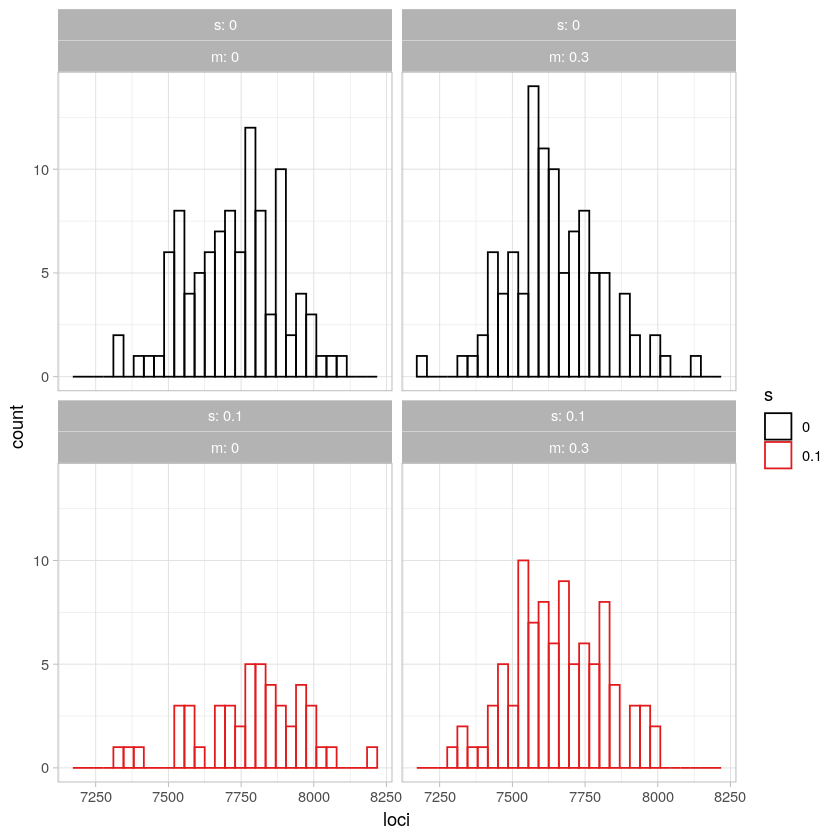

In [38]:
hapflk %>%
        dplyr::select(pos, replicate,s,m)%>%
        distinct() %>%
        group_by(replicate,s,m) %>%
        summarise(loci=n()) %>%
        ggplot() +
        geom_histogram(aes(x=loci, color = s), fill= NA) +
        wrap_by(s,m) +
        theme_light() +
        scale_color_manual(values=c( "black", "#e31a1c"))

La poblacion que esta bajo seleccion es p4, en el escenario con m=0, la mutacion adaptativa probabemente se perdió antes del sweep.

Warning message:
“Removed 39981 rows containing missing values (geom_point).”
Warning message:
“Removed 72878 rows containing missing values (geom_point).”


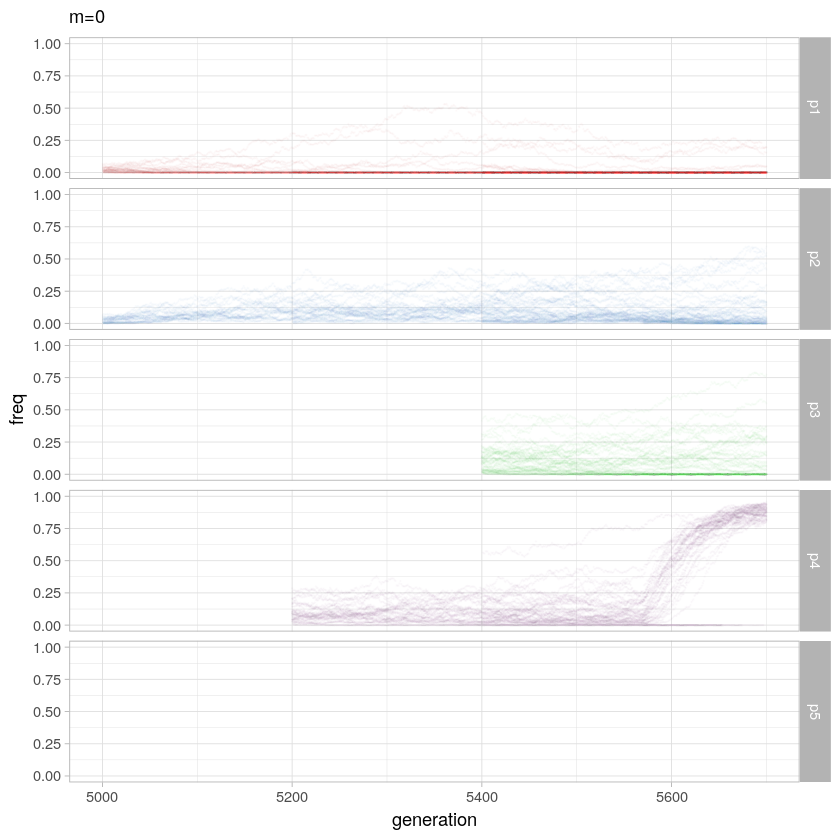

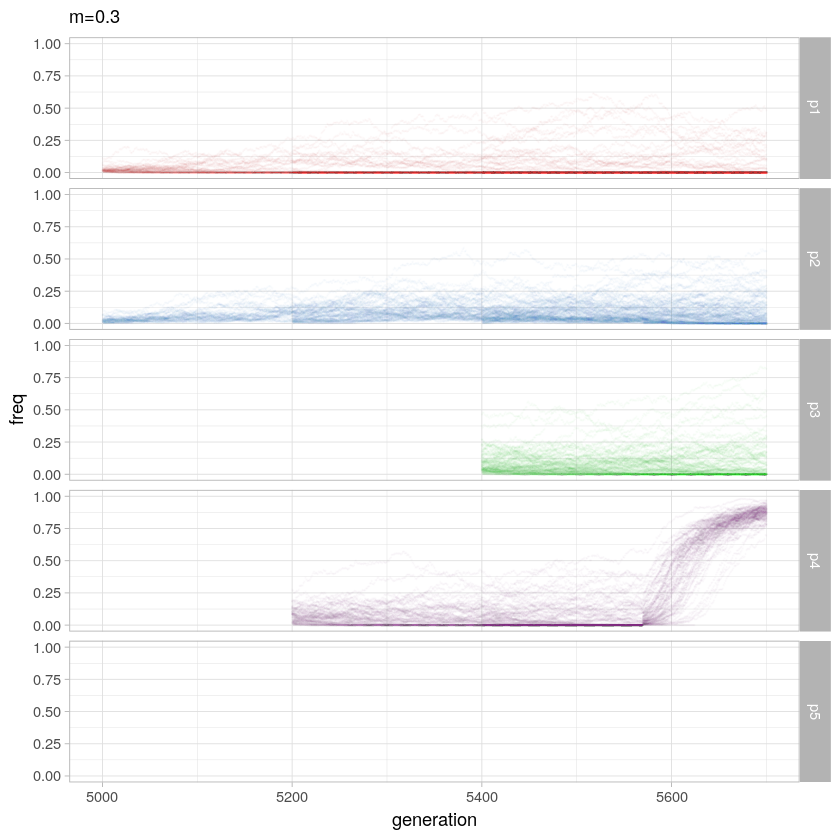

In [39]:
plotFrequencies(frequencies,0.1,0)
plotFrequencies(frequencies,0.1,0.3)


# Statistics QC

## Statistics distribution

View distribution of FLK values for no admixture scenario (m=0) and for admixture scenario (m=0.3).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 157691 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 157691 rows containing non-finite values (stat_density).”


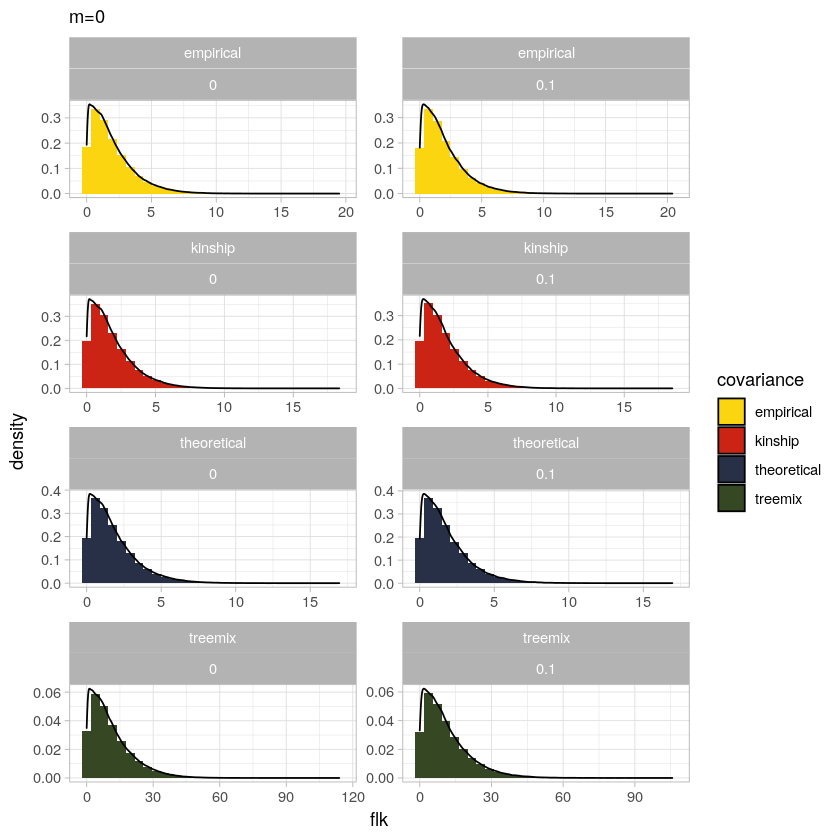

In [40]:
hapflk %>%
    filter(m==0) %>%
    ggplot(aes(x=flk, y = ..density..)) +
    geom_histogram(aes(fill=covariance)) +
    geom_density() +
    facet_wrap(~covariance+s, scales = "free", ncol=2) +
    theme_light() +
    labs(subtitle = paste0("m=",0)) +
    scale_fill_manual(values = colors)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 208202 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 208202 rows containing non-finite values (stat_density).”


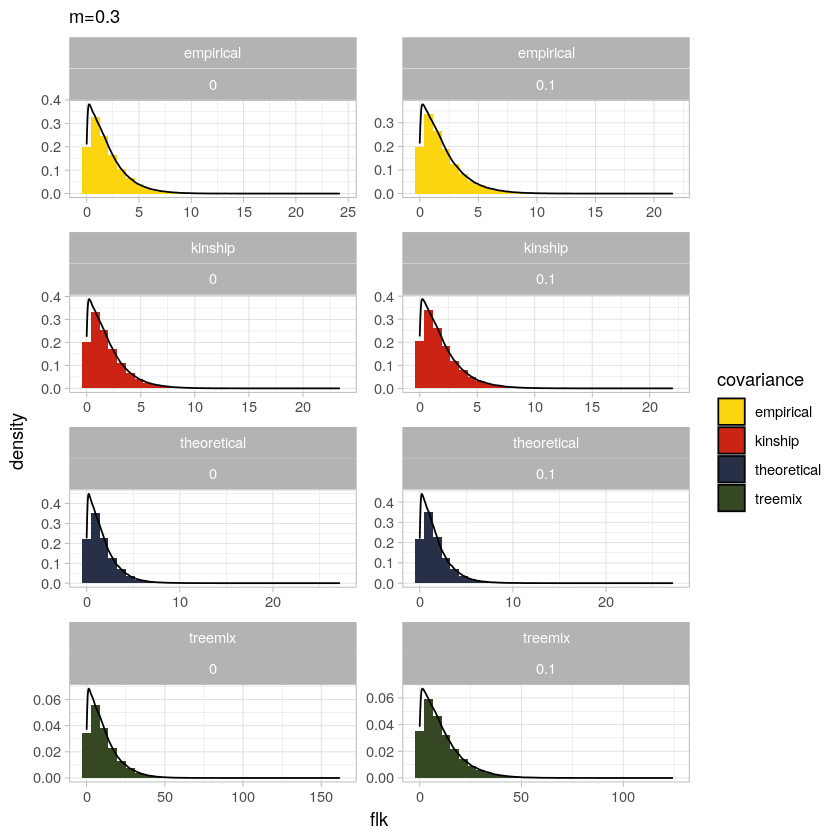

In [41]:
hapflk %>%
    filter(m==0.3) %>%
    ggplot(aes(x=flk, y = ..density..)) +
    geom_histogram(aes(fill=covariance)) +
    geom_density() +
    facet_wrap(~covariance+s, scales = "free", ncol=2) +
    theme_light() +
    labs(subtitle = paste0("m=",0.3)) +
    scale_fill_manual(values = colors)

Now compute values of **hapFLK** for no migration and migration.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



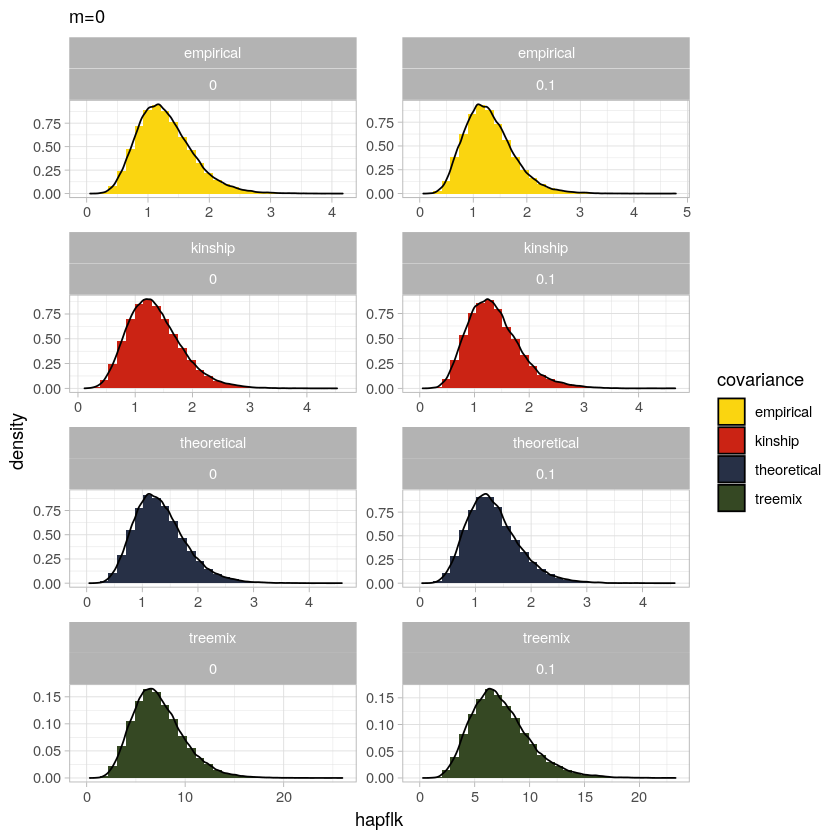

In [42]:
hapflk %>%
    filter(m==0) %>%
    ggplot(aes(x=hapflk, y = ..density..)) +
    geom_histogram(aes(fill=covariance)) +
    geom_density() +
    facet_wrap(~covariance+s, scales = "free", ncol=2) +
    theme_light() +
    labs(subtitle = paste0("m=",0)) +
    scale_fill_manual(values = colors)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



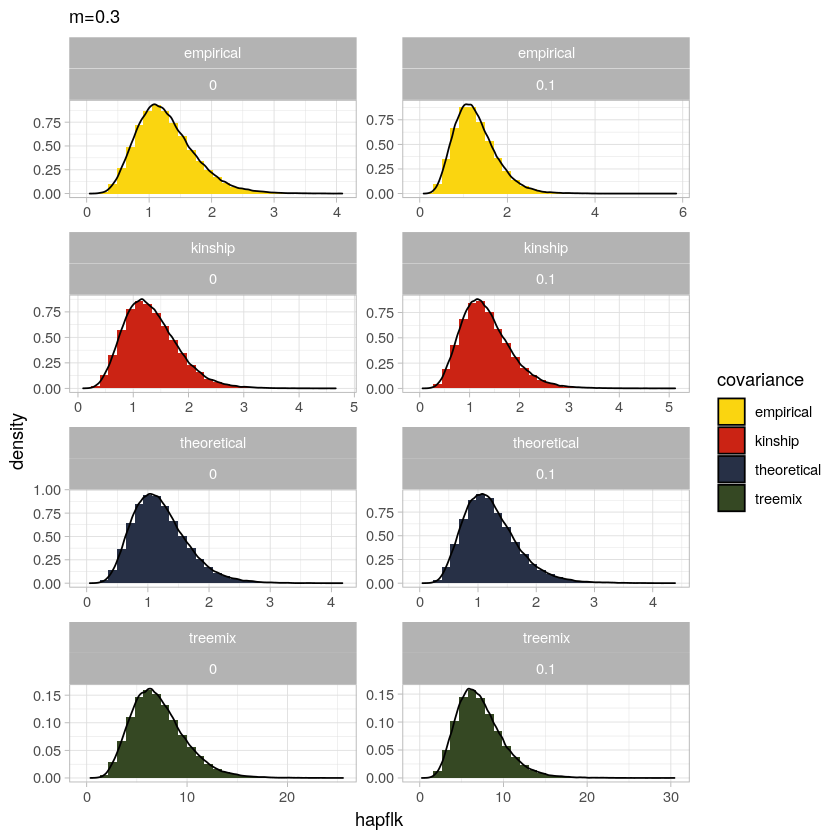

In [43]:
hapflk %>%
    filter(m==0.3) %>%
    ggplot(aes(x=hapflk, y = ..density..)) +
    geom_histogram(aes(fill=covariance)) +
    geom_density() +
    facet_wrap(~covariance+s, scales = "free", ncol=2) +
    theme_light() +
    labs(subtitle = paste0("m=",0.3)) +
    scale_fill_manual(values = colors)

We can more clearly compare the distributions in an overimposed plot. First for the FLK statistic and then for the hapFLK statistic.

Warning message:
“Removed 157691 rows containing non-finite values (stat_density).”


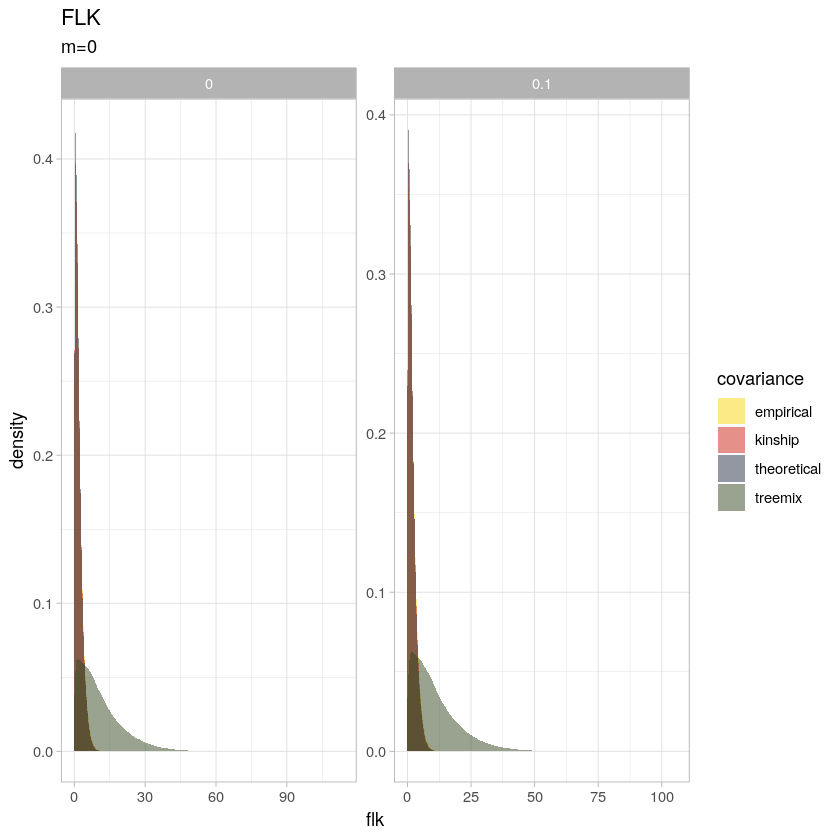

In [62]:
hapflk %>%
    filter(m==0) %>%
    ggplot(aes(x=flk)) +
    geom_density(aes(fill=covariance),color=NA,alpha = 0.5) +
    facet_wrap(~s, scales = "free") +
    labs(subtitle = paste0("m=",0), title="FLK") +
    theme_light() +
    scale_fill_manual(values = colors)

Warning message:
“Removed 208202 rows containing non-finite values (stat_density).”


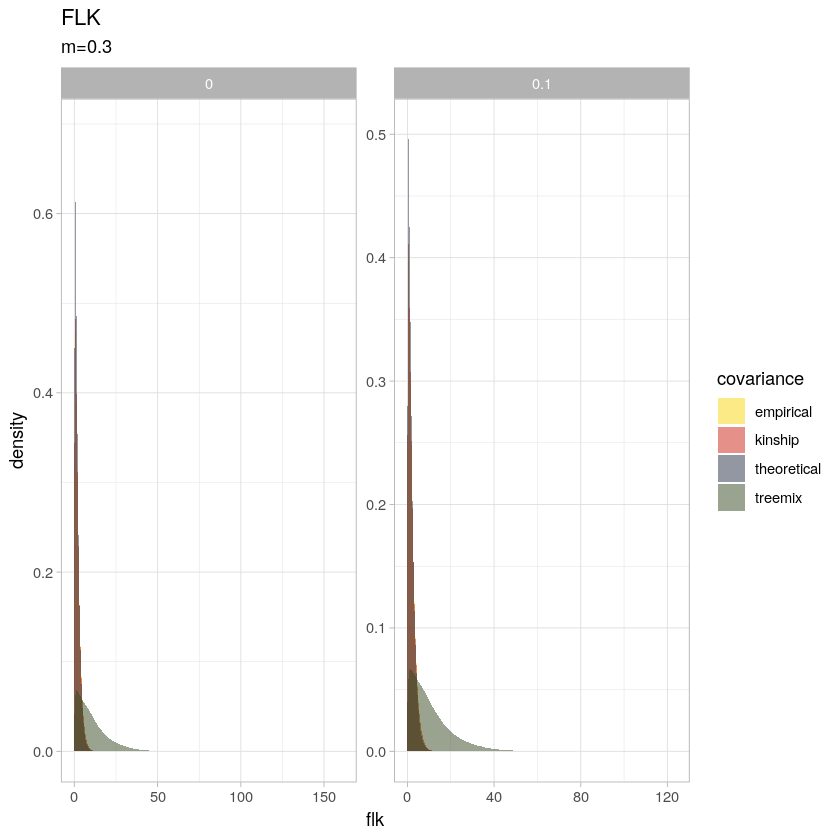

In [63]:
hapflk %>%
    filter(m==0.3) %>%
    ggplot(aes(x=flk)) +
    geom_density(aes(fill=covariance),color=NA,alpha = 0.5) +
    facet_wrap(~s, scales = "free") +
    labs(subtitle = paste0("m=",0.3), title="FLK") +
    theme_light() +
    scale_fill_manual(values = colors)

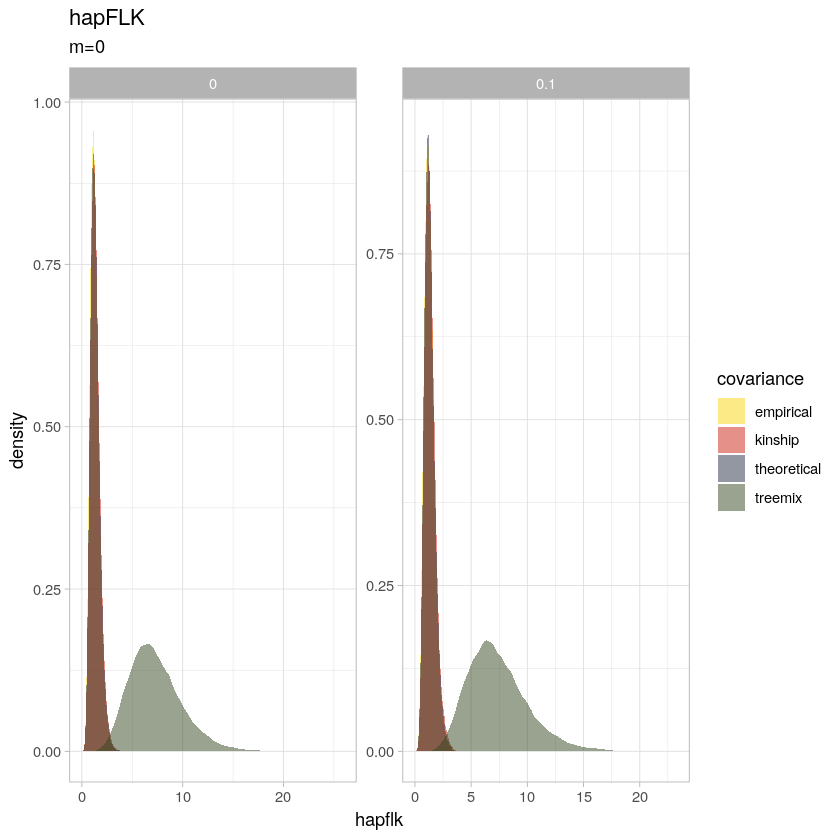

In [64]:
hapflk %>%
    filter(m==0) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance),color=NA,alpha = 0.5) +
    facet_wrap(~s, scales = "free") +
    labs(subtitle = paste0("m=",0), title="hapFLK") +
    theme_light() +
    scale_fill_manual(values = colors)

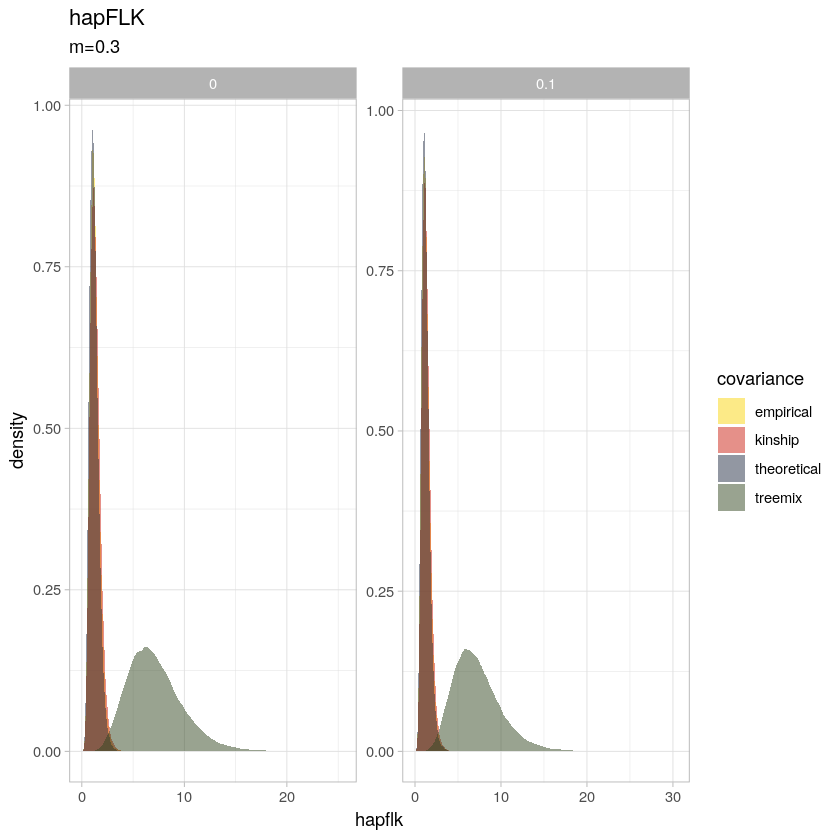

In [65]:
hapflk %>%
    filter(m==0.3) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance),color=NA,alpha = 0.5) +
    facet_wrap(~s, scales = "free") +
    labs(subtitle = paste0("m=",0.3), title="hapFLK") +
    theme_light() +
    scale_fill_manual(values = colors)

All covariance estimation methods look similar except for treemix which appears to be a scaled version of the other ones.

## Statistics goodness-of-fit

### Chi-squared distribution

qqplots are not very informative when superimposed and faceted this way, so let's plot them by m and s, and facet them according to covariance matrices in a square manner. First, define a function to make code more compact.

In [66]:
qqplot_flk <- function(input_df,scoef,mcoef){
    hapflk %>% 
    filter(m==mcoef) %>%
    filter(s==scoef) %>%
    ggplot(., mapping = aes(sample = flk,color = covariance)) +
      stat_qq_band(distribution="chisq",dparams=list("df" = flk_df)) +
      stat_qq_line(distribution="chisq",dparams=list("df" = flk_df)) +
      stat_qq_point(distribution="chisq",dparams=list("df" = flk_df)) +
      facet_wrap(~covariance, scales = "free", ncol=2) +
      labs(subtitle = paste0("m=",mcoef,",","s=",scoef)) +
      xlab("Theoretical Quantiles") +
      ylab("Sample Quantiles") +
      theme_light() +
      ggtitle(bquote("FLK QQ plot "~chi^2~ ~(.(flk_df)))) +
      scale_color_manual(values = colors)
}

In [63]:
#qqplot_flk(hapflk, 0,0)
#qqplot_flk(hapflk, 0.1,0)
#qqplot_flk(hapflk, 0,0.3)
#qqplot_flk(hapflk, 0.1,0.3)

Now compute goodness-of-fit for hapFLK values.

In [60]:
qqplot_hapflk <- function(input_df,scoef,mcoef){
    hapflk %>% 
    filter(m==mcoef) %>%
    filter(s==scoef) %>%
    ggplot(., mapping = aes(sample = hapflk,color = covariance)) +
      stat_qq_band(distribution="chisq",dparams=list("df" = hapflk_df)) +
      stat_qq_line(distribution="chisq",dparams=list("df" = hapflk_df)) +
      stat_qq_point(distribution="chisq",dparams=list("df" = hapflk_df)) +
      facet_wrap(~covariance, scales = "free", ncol=2) +
      labs(subtitle = paste0("m=",mcoef,",","s=",scoef)) +
      xlab("Theoretical Quantiles") +
      ylab("Sample Quantiles") +
      theme_light() +
      ggtitle(bquote("hapFLK QQ plot "~chi^2~ ~(.(hapflk_df)))) +
      scale_color_manual(values = colors)
}

In [69]:
pdf("./qqplots_chisq.pdf")
qqplot_hapflk(hapflk, 0,0)
qqplot_hapflk(hapflk, 0.1,0)
qqplot_hapflk(hapflk, 0,0.3)
qqplot_hapflk(hapflk, 0.1,0.3)
dev.off()

png 
  2

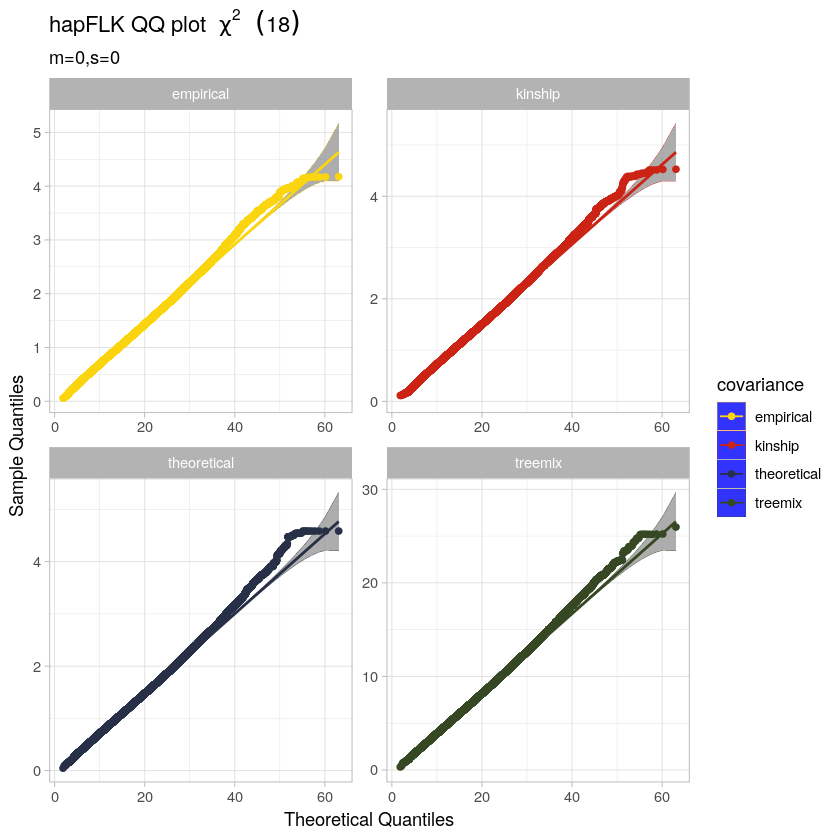

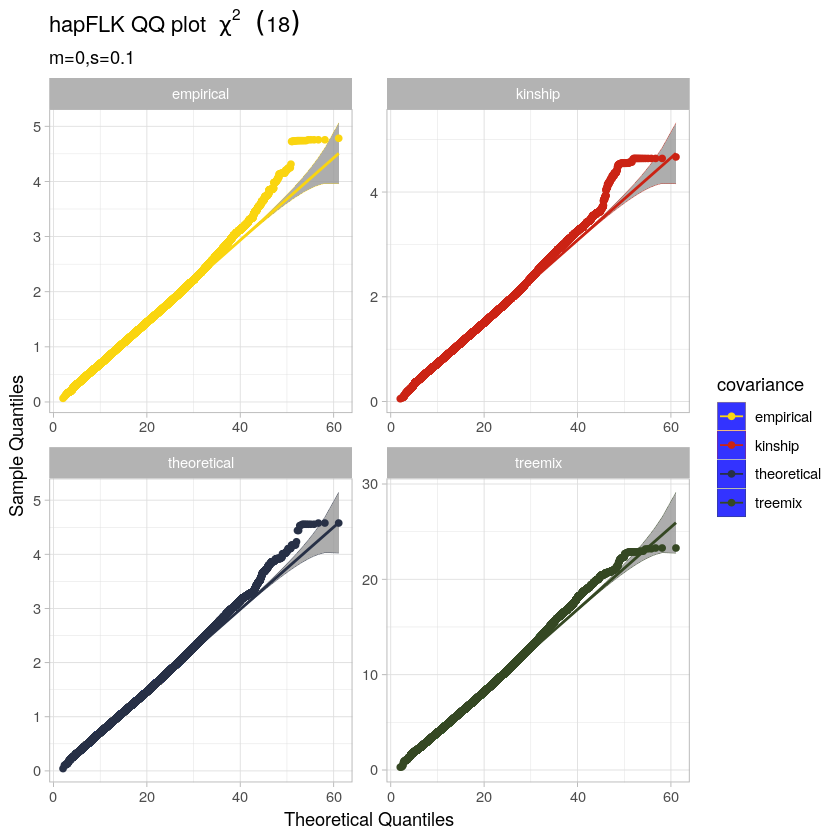

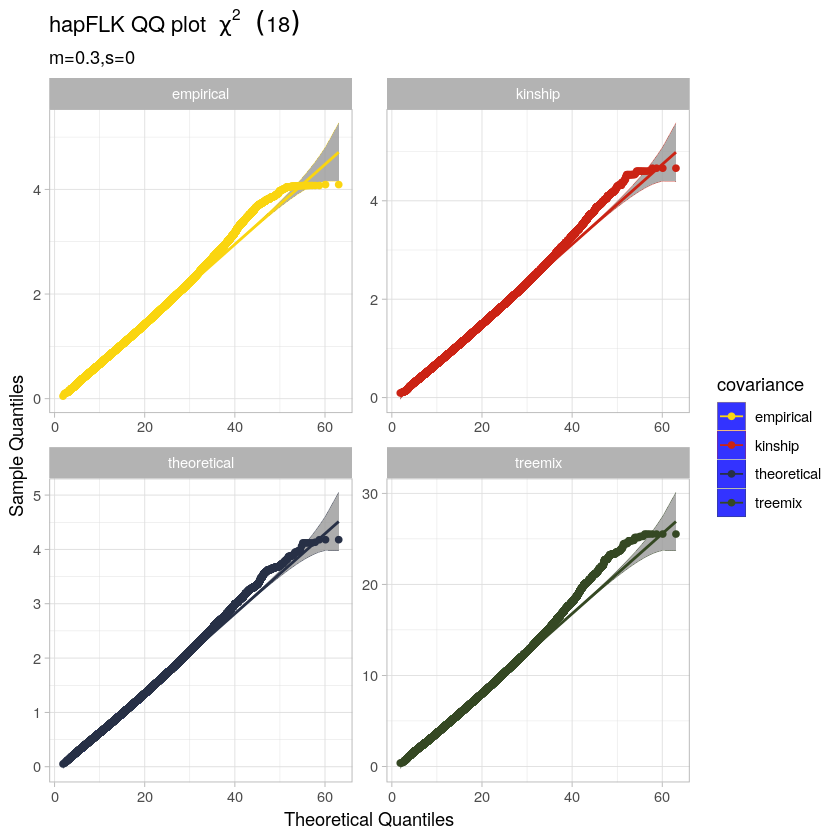

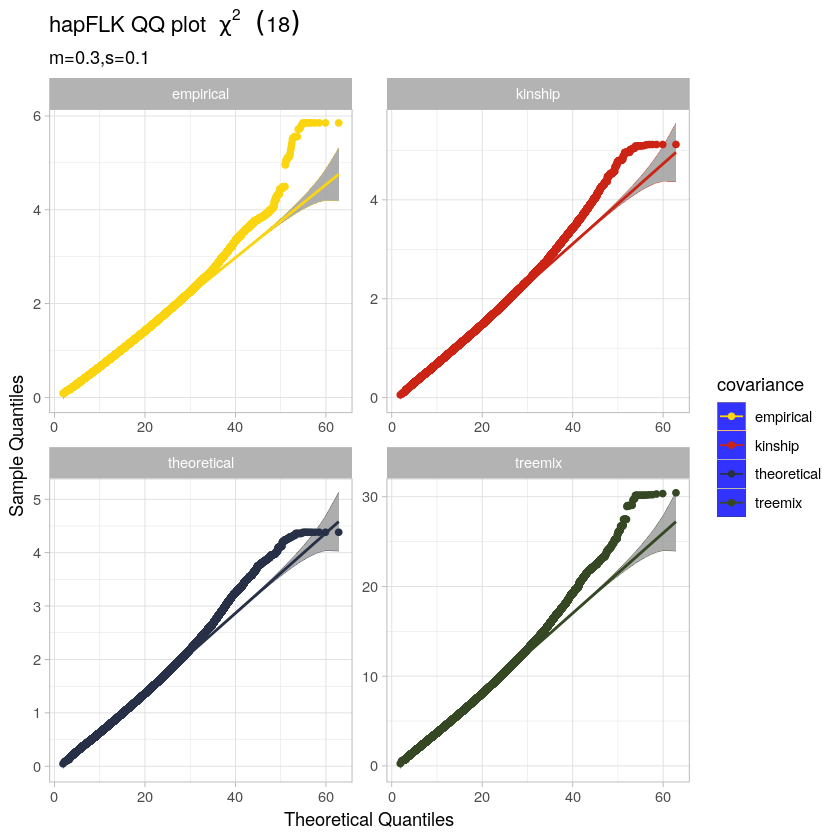

In [70]:
qqplot_hapflk(hapflk, 0,0)
qqplot_hapflk(hapflk, 0.1,0)
qqplot_hapflk(hapflk, 0,0.3)
qqplot_hapflk(hapflk, 0.1,0.3)

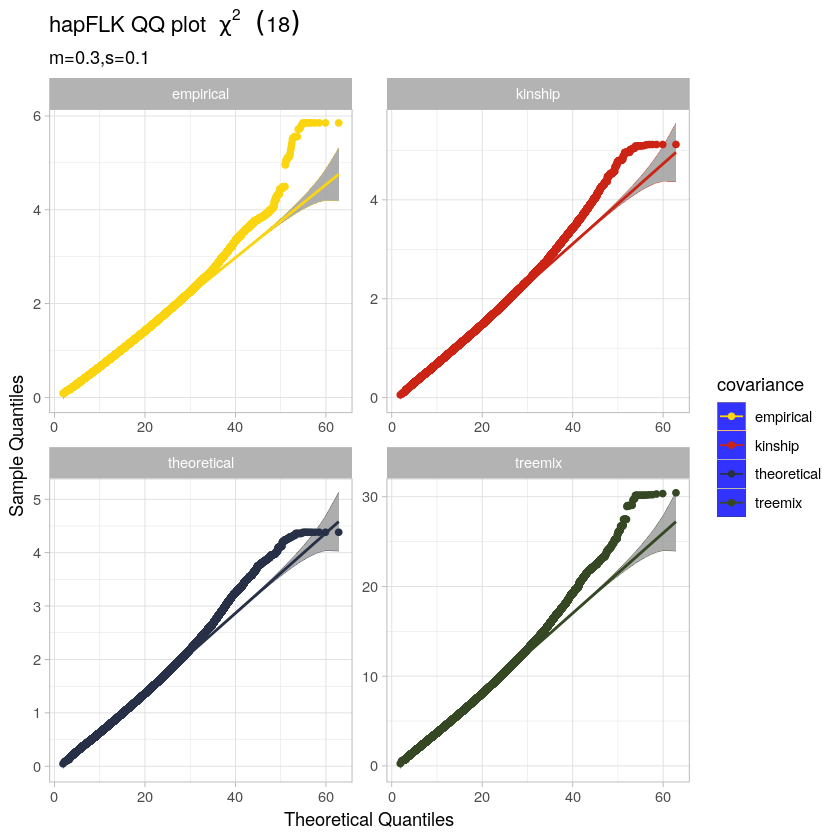

In [72]:
hapflk %>% 
    filter(replicate==9) %>%
    qqplot_hapflk(., 0.1,0.3)

Let’s explore in more detail how good the statistics fit to a χ2 by plotting joint density plots for the empirical and theoretical distributions.

Warning message:
“Removed 341178 rows containing non-finite values (stat_density).”


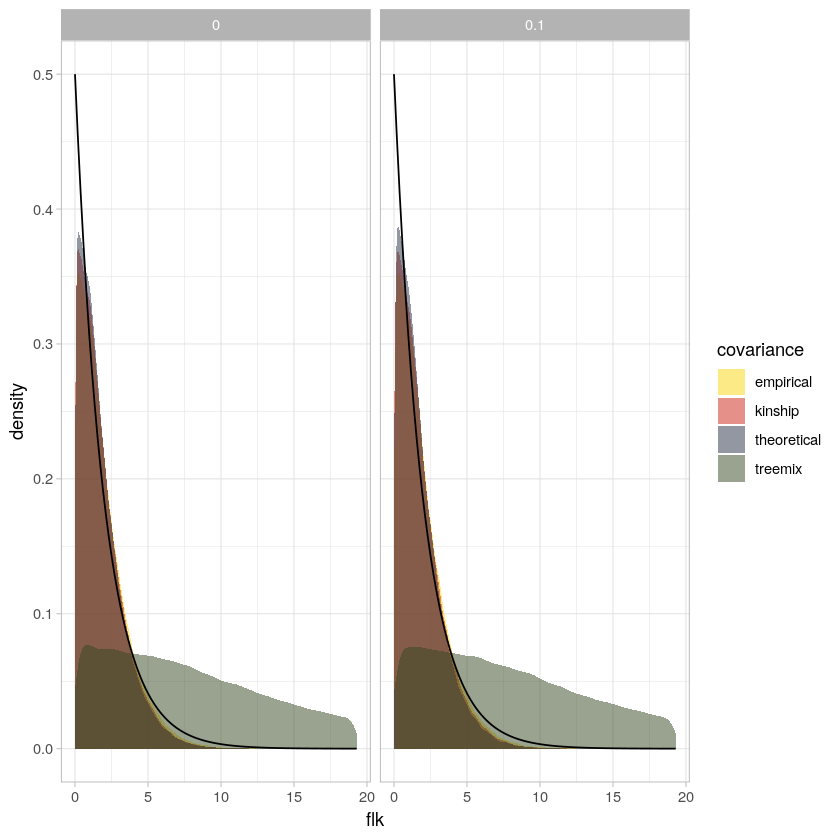

In [70]:
hapflk %>% filter(m==0) %>%
    ggplot(aes(x=flk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5) +
    stat_function(fun = dchisq, args = list(df=flk_df)) +
    xlim(0,max(rchisq(n=1000,df=flk_df))) +
    facet_wrap(~s) +
    theme_light() +
    scale_fill_manual(values = colors)

Warning message:
“Removed 425300 rows containing non-finite values (stat_density).”


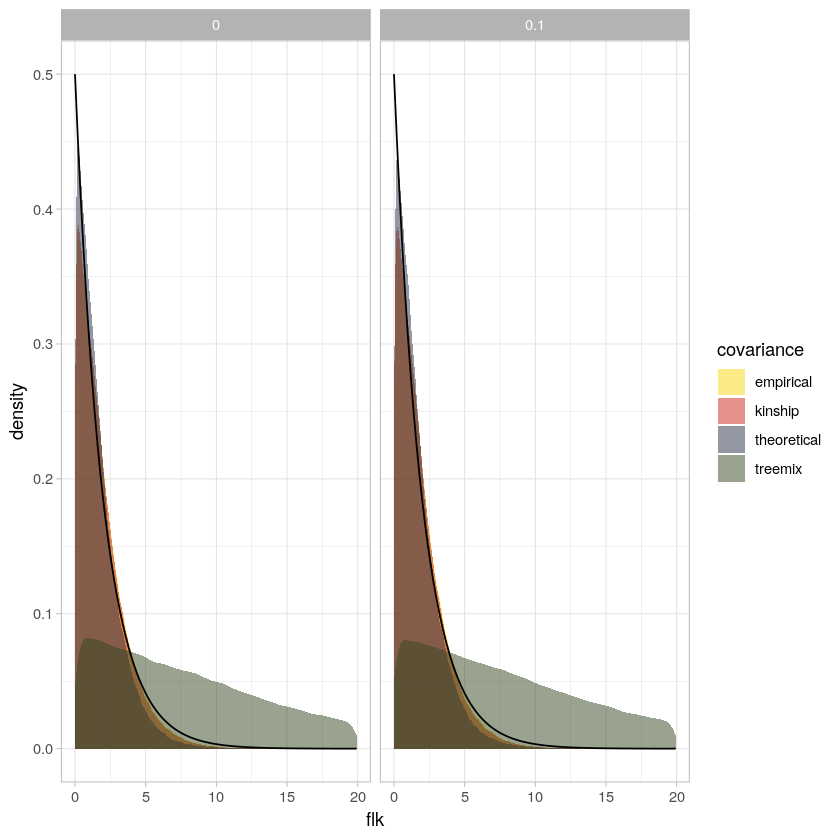

In [71]:
hapflk %>% filter(m==0.3) %>%
    ggplot(aes(x=flk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5) +
    stat_function(fun = dchisq, args = list(df=flk_df)) +
    xlim(0,max(rchisq(n=1000,df=flk_df))) +
    facet_wrap(~s) +
    theme_light() +
    scale_fill_manual(values = colors)

Now, for hapflk statistic.

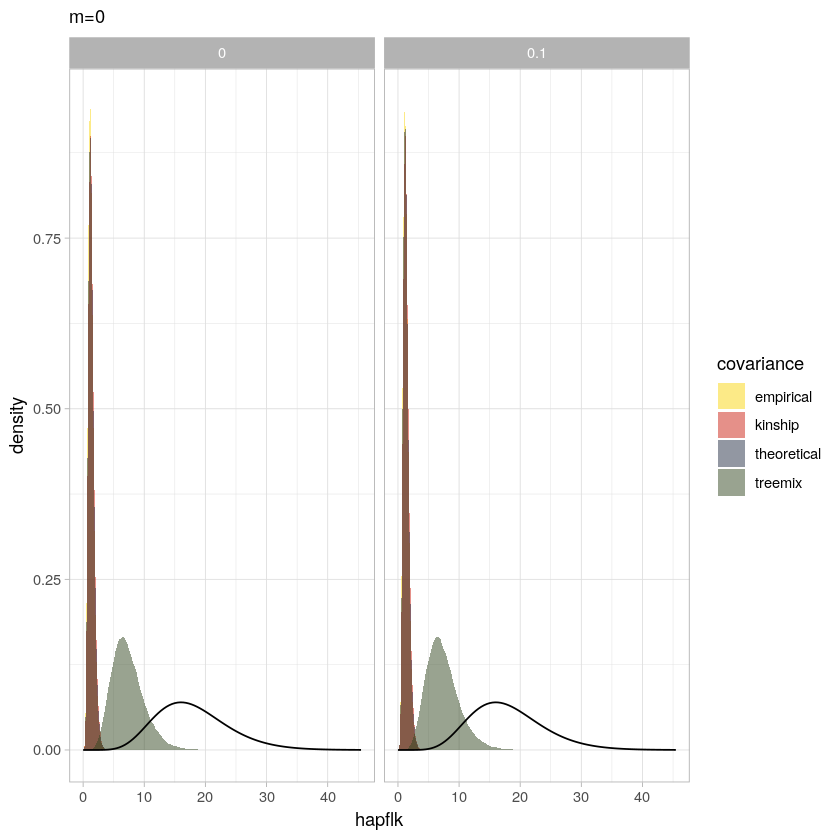

In [11]:
mcoef <- 0
hapflk %>% 
    filter(m==mcoef) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    stat_function(fun = dchisq, args = list(df=hapflk_df)) +
    xlim(0,max(rchisq(n=1000,df=hapflk_df))) +
    facet_wrap(~s) +
    labs(subtitle = paste0("m=",mcoef)) +
    theme_light() +
    scale_fill_manual(values = colors)

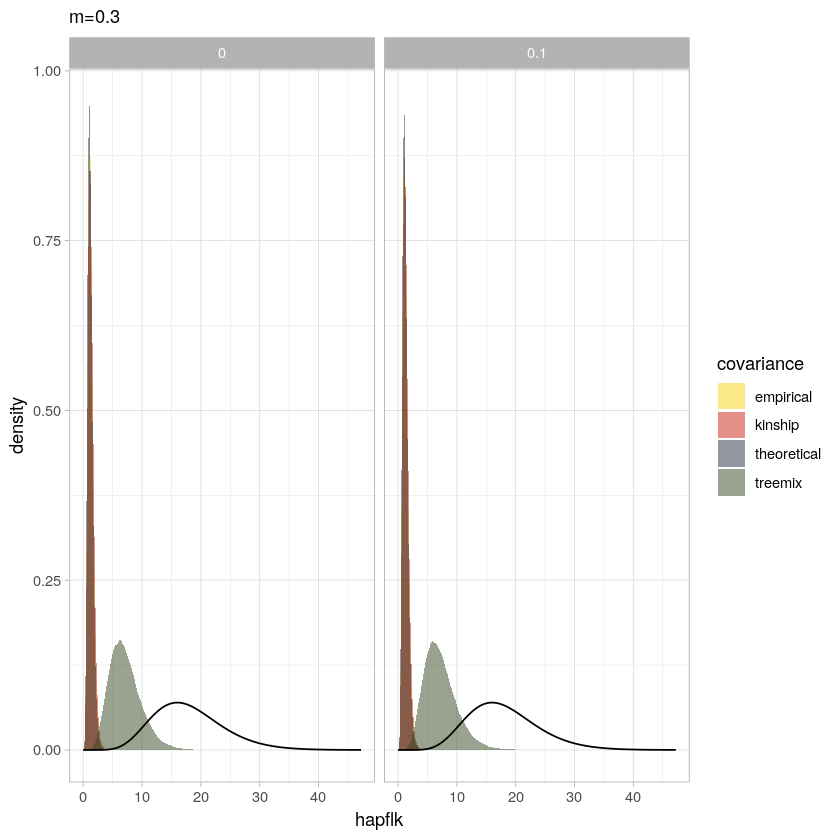

In [12]:
mcoef <- 0.3
hapflk %>% 
    filter(m==mcoef) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    stat_function(fun = dchisq, args = list(df=hapflk_df)) +
    xlim(0,max(rchisq(n=1000,df=hapflk_df))) +
    labs(subtitle = paste0("m=",mcoef)) +
    facet_wrap(~s) +
    theme_light() +
    scale_fill_manual(values = colors)

hapFLK statistic not looking so good.

Assuming the fit is good, lets compute p-values and q-values of hapFLK for each run, plot their distribution, and compare them in manhattan plots.

In [10]:
hapflk <-hapflk %>%
          group_by(covariance,replicate, s,m) %>%
          mutate( pval = 1-pchisq(hapflk, df = hapflk_df) ) %>%
          mutate( qval = p.adjust(pval, method = "fdr")) 

In [11]:
hapflk

chr pos     flk        replicate covariance hapflk    m   s  
1        1    3818    1.584112  9         treemix     5.019443 0   0  
2        1    6641   13.125145  9         treemix     5.019785 0   0  
3        1    6842   25.285345  9         treemix     5.175674 0   0  
4        1    8696   12.668436  9         treemix     5.185416 0   0  
5        1    9433   12.955504  9         treemix     5.185420 0   0  
6        1   11923   25.288429  9         treemix     8.083822 0   0  
7        1   16324   27.365015  9         treemix     8.083833 0   0  
8        1   17997   11.387609  9         treemix     8.139637 0   0  
9        1   18193   16.658178  9         treemix     8.139641 0   0  
10       1   18829   10.754239  9         treemix     8.139762 0   0  
11       1   19200    3.757574  9         treemix     8.166570 0   0  
12       1   20364    9.465695  9         treemix     8.686100 0   0  
13       1   20886          NA  9         treemix     8.686104 0   0  
14       1   21266    5.559144  9         treemix     8.686109 0   0  
15       1   25486   19.846917  9         treemix     8.686667 0   0  
16       1   26760   35.043432  9         treemix     8.691938 0   0  
17       1   29650   41.418315  9         treemix    11.377642 0   0  
18       1   30421   12.833111  9         treemix    11.377644 0   0  
19       1   30524   18.508612  9         treemix    11.377647 0   0  
20       1   33135   23.751628  9         treemix    11.377642 0   0  
21       1   33270   23.935830  9         treemix    11.377639 0   0  
22       1   33549   27.491869  9         treemix    12.373931 0   0  
23       1   34065   24.340276  9         treemix    12.373909 0   0  
24       1   36701   13.305605  9         treemix    12.357595 0   0  
25       1   39247   15.896040  9         treemix    12.357579 0   0  
26       1   43074    6.974241  9         treemix     7.610522 0   0  
27       1   44458    3.307922  9         treemix     7.583982 0   0  
28       1   45324    3.307922  9         treemix     7.583396 0   0  
29       1   46257    8.036669  9         treemix     7.440827 0   0  
30       1   48623    9.309920  9         treemix     7.337125 0   0  
⋮        ⋮   ⋮       ⋮          ⋮         ⋮          ⋮         ⋮   ⋮  
12311171 1   9941281 1.37792711 100       empirical  0.9331217 0.3 0.1
12311172 1   9941847 0.32272277 100       empirical  0.9331361 0.3 0.1
12311173 1   9944467 0.20522801 100       empirical  0.9721197 0.3 0.1
12311174 1   9951150 1.43854441 100       empirical  1.2175311 0.3 0.1
12311175 1   9951318 0.01458743 100       empirical  1.2193855 0.3 0.1
12311176 1   9953846 1.40885802 100       empirical  1.3487969 0.3 0.1
12311177 1   9955604 1.33415478 100       empirical  1.3687171 0.3 0.1
12311178 1   9958685 1.60250855 100       empirical  1.5378085 0.3 0.1
12311179 1   9961513 4.61828748 100       empirical  1.5651664 0.3 0.1
12311180 1   9962347 3.65238597 100       empirical  1.5678753 0.3 0.1
12311181 1   9962398 3.65238597 100       empirical  1.5678850 0.3 0.1
12311182 1   9963386 3.90262648 100       empirical  1.5678950 0.3 0.1
12311183 1   9964666 3.65238597 100       empirical  1.5662238 0.3 0.1
12311184 1   9966474 4.76249927 100       empirical  1.4331359 0.3 0.1
12311185 1   9966723 4.76249927 100       empirical  1.4331353 0.3 0.1
12311186 1   9976534 1.54551230 100       empirical  1.4207487 0.3 0.1
12311187 1   9977535 1.54551230 100       empirical  1.4213703 0.3 0.1
12311188 1   9978015 1.54551230 100       empirical  1.4219908 0.3 0.1
12311189 1   9982211 7.41248488 100       empirical  1.4654927 0.3 0.1
12311190 1   9982219 7.41248488 100       empirical  1.4654929 0.3 0.1
12311191 1   9983280         NA 100       empirical  1.4567176 0.3 0.1
12311192 1   9984664 7.33558212 100       empirical  1.4540403 0.3 0.1
12311193 1   9986109 3.29440385 100       empirical  1.4540397 0.3 0.1
12311194 1   9990668 0.28129869 100       empirical  1.4493659 0.3 0.1
12311195 1   9991214 0.12738992 1

Draw p-value histograms

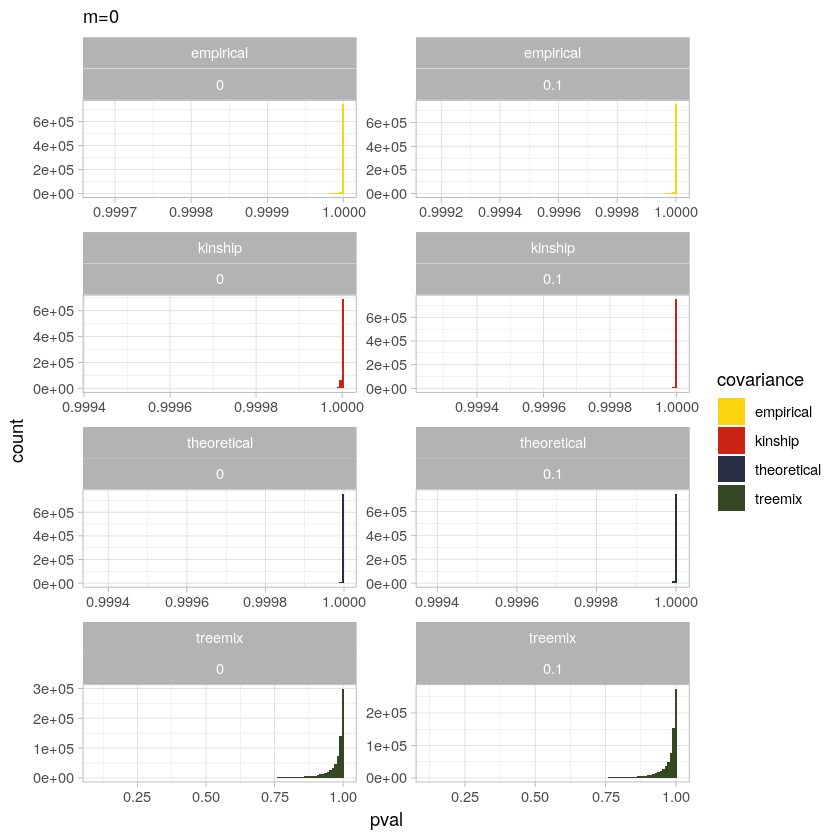

In [20]:
mcoef <- 0 
hapflk %>% filter(m==mcoef) %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins=100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

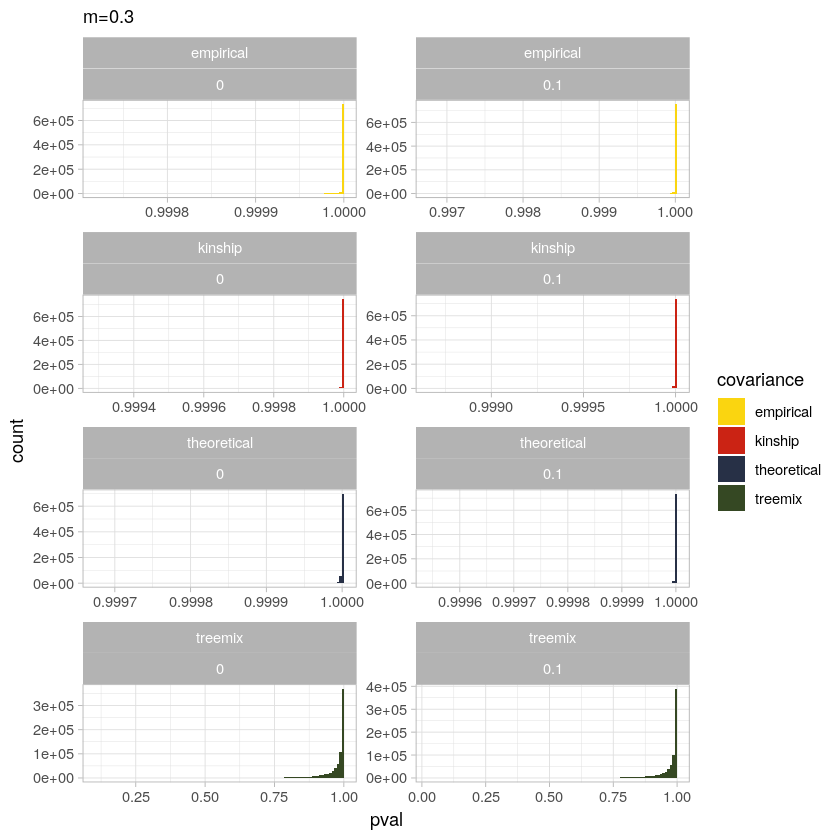

In [19]:
mcoef <- 0.3
hapflk %>% filter(m==mcoef) %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

Let's see p-value manhattan plots

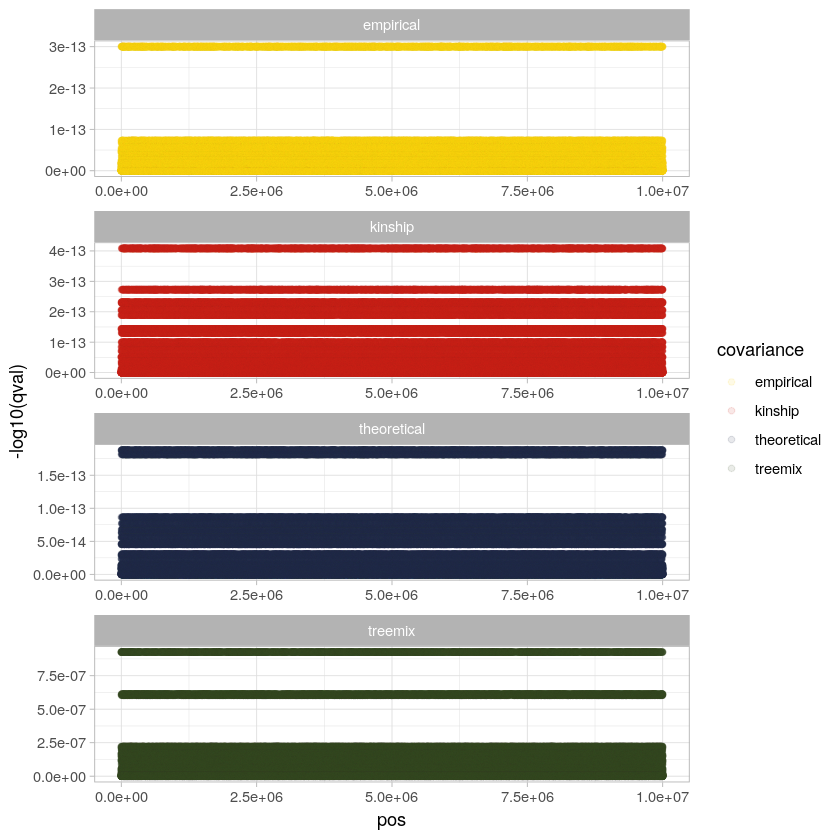

In [77]:
hapflk %>% filter(m==0) %>%
  filter(s==0.1) %>%
  ggplot(., aes(x=pos, y = -log10(qval))) +
  geom_point( aes(color=covariance), alpha = 0.1 ) +
  facet_wrap(~covariance, ncol = 1, scales="free") +
  theme_light()+
  scale_color_manual(values = colors)

### Normal distribution

Same as qqplots for chi-squared distribution, define a function for faceting according to m and s.

In [78]:
qqplot_hapflk_normal <- function(input_df,scoef,mcoef){
    input_df %>% 
    filter(m==mcoef&s==scoef) %>%
    ggplot(., mapping = aes(sample = hapflk,color = covariance)) +
      stat_qq_band() +
      stat_qq_line() +
      stat_qq_point() +
      labs(subtitle = paste0("m=",mcoef,",","s=",scoef)) +
      facet_wrap(~covariance, scales = "free") +
      xlab("Theoretical Quantiles") +
      ylab("Sample Quantiles") +
      theme_light() +
      ggtitle(bquote("hapFLK QQ plot "~N(mu,sigma) )) +
      scale_color_manual(values = colors)
}

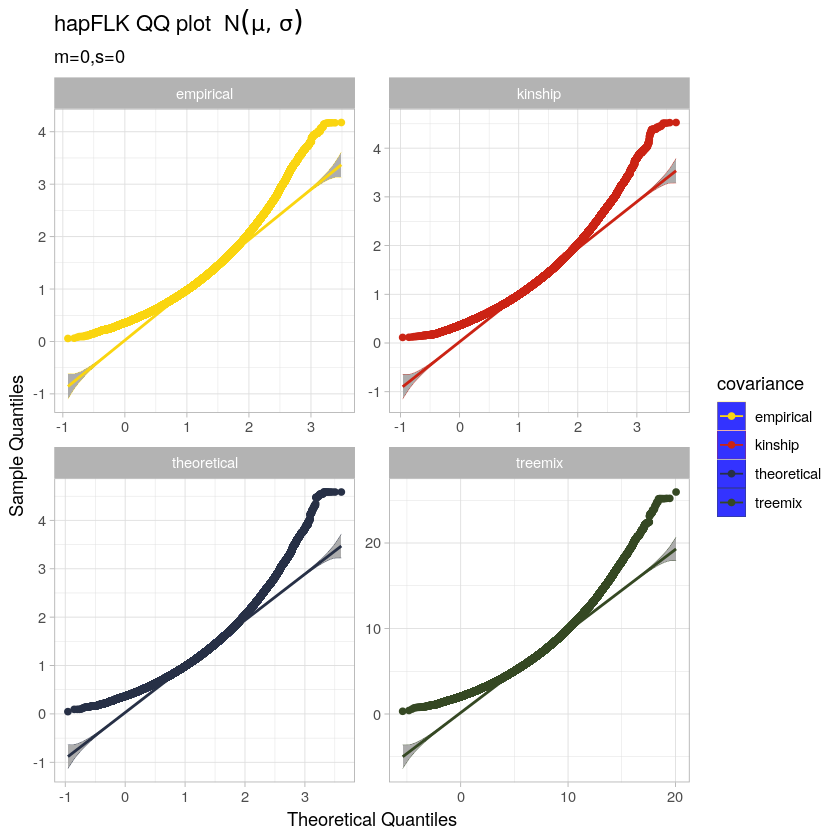

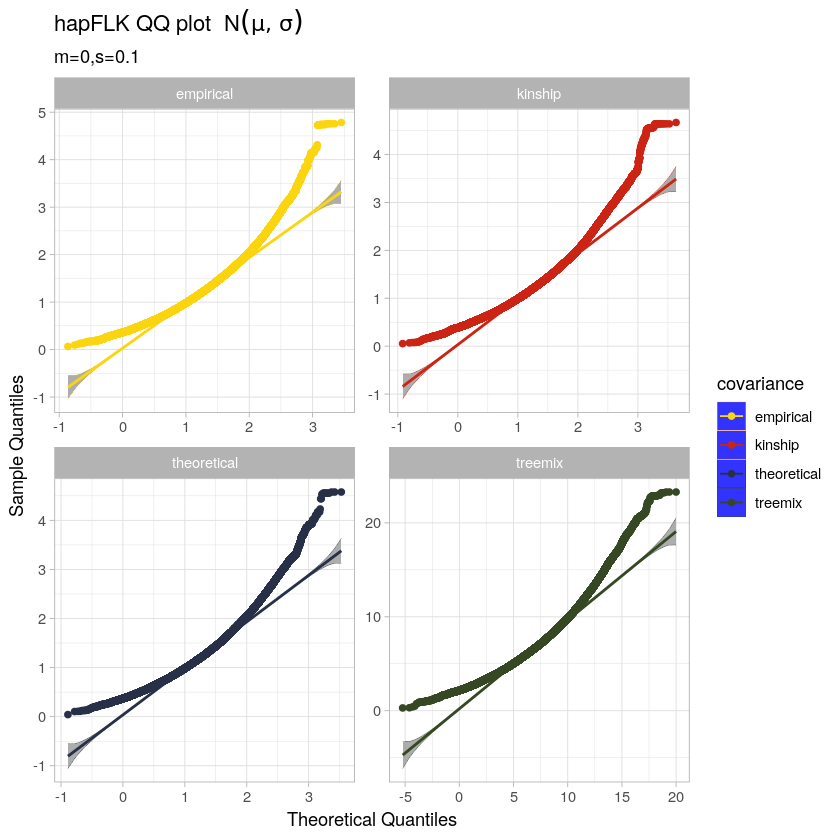

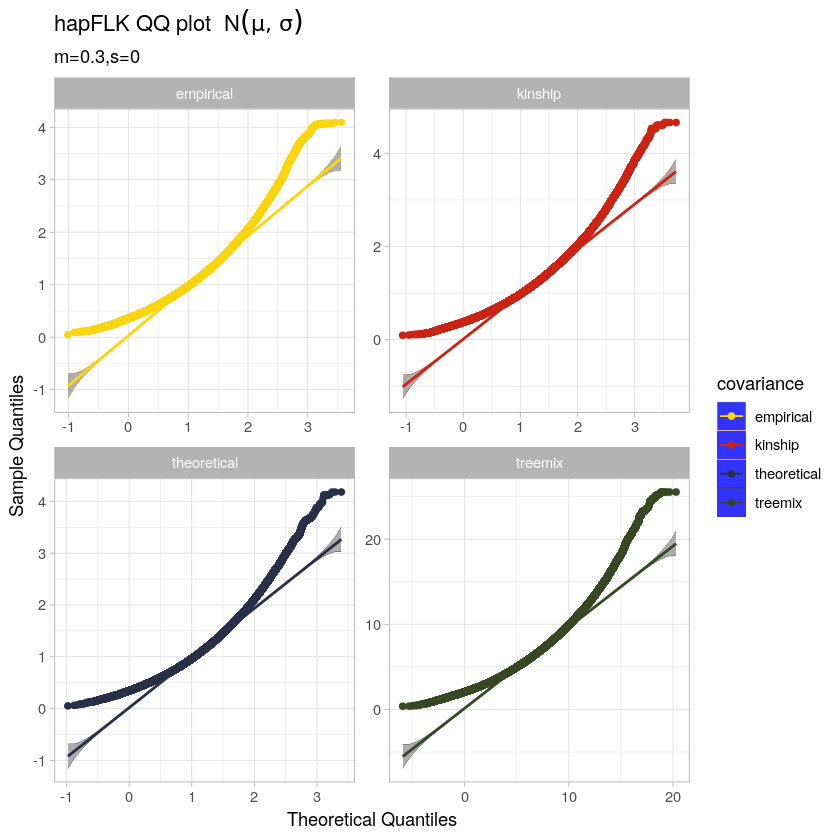

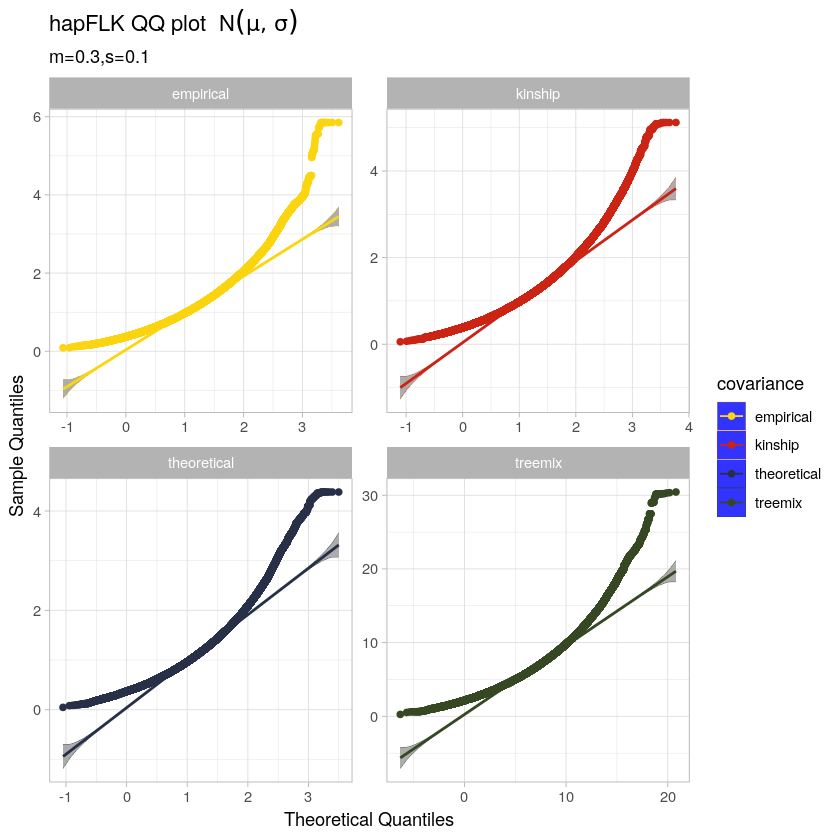

In [79]:
pdf("./qqplots_normal.pdf")
qqplot_hapflk_normal(hapflk, 0,0)
qqplot_hapflk_normal(hapflk, 0.1,0)
qqplot_hapflk_normal(hapflk, 0,0.3)
qqplot_hapflk_normal(hapflk, 0.1,0.3)
dev.off()

I could visualize the Kernel Density Estimates together with the theoretical distributions. But I won't do it right now.

Assuming hapFLK follows a normal distribution, compute p-values and q-values. Make p values histograms and Manhattan plots.


In [24]:
hapflk <- hapflk %>% 
          group_by( replicate, covariance, s,m ) %>%
          mutate( pval = 1- pnorm(hapflk , mean(hapflk),sd(hapflk))  ) %>%
          mutate( qval = p.adjust(pval, "fdr"))

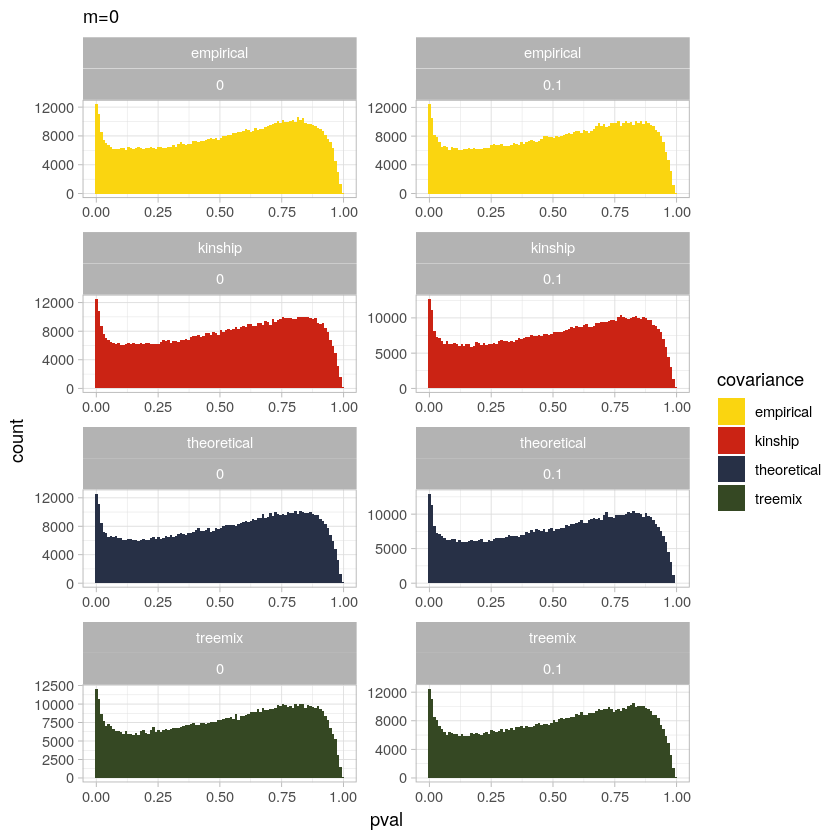

In [25]:
mcoef <- 0.0
hapflk %>% filter(m==mcoef) %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

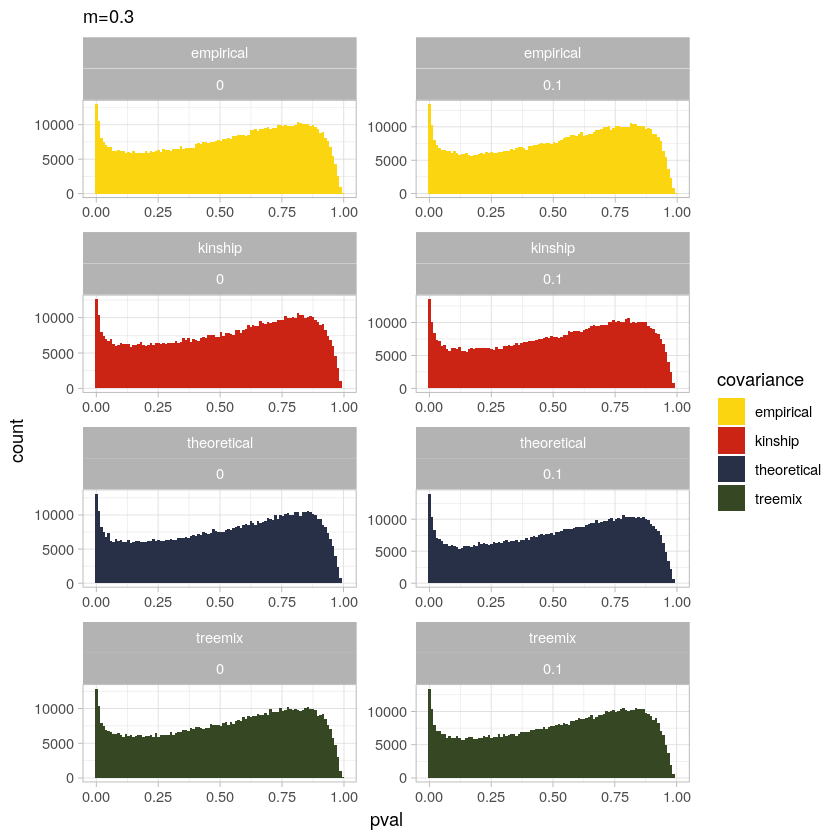

In [26]:
mcoef <- 0.3
hapflk %>% filter(m==mcoef) %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

Manhattan plots now (only for selection scenarios)

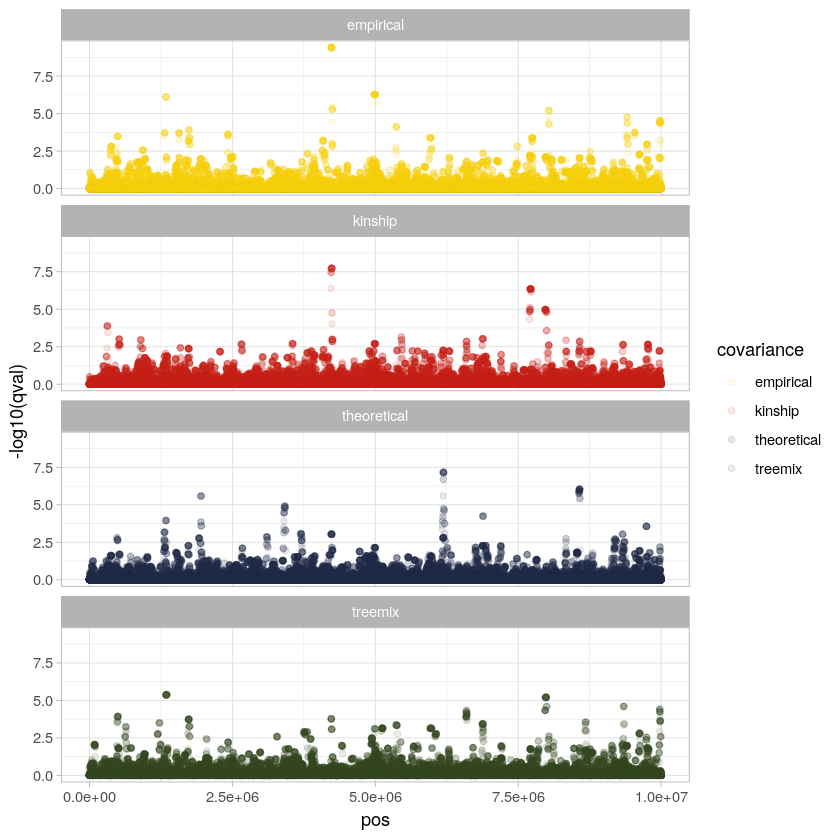

In [83]:
hapflk %>% filter(m==0) %>%
  filter(s==0.1) %>%
  ggplot(., aes(x=pos, y = -log10(qval))) +
  geom_point( aes(color=covariance), alpha = 0.1 ) +
  facet_wrap(~covariance, ncol = 1) +
  theme_light()+
  scale_color_manual(values = colors)

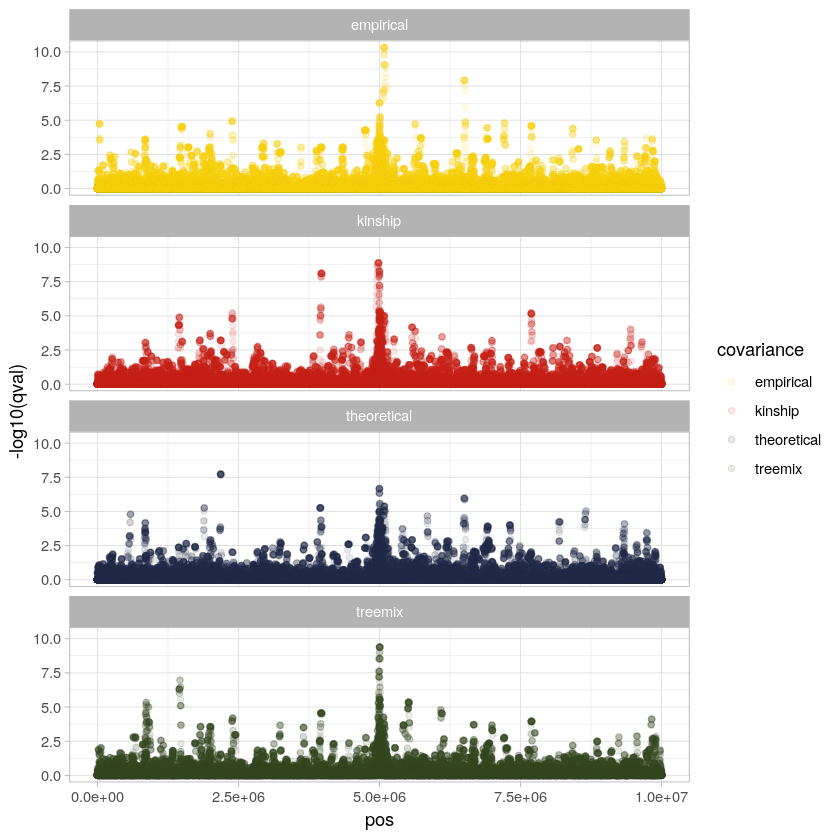

In [84]:
hapflk %>% filter(m==0.3) %>%
  filter(s==0.1) %>%
  ggplot(., aes(x=pos, y = -log10(qval))) +
  geom_point( aes(color=covariance), alpha = 0.1 ) +
  facet_wrap(~covariance, ncol = 1) +
  theme_light()+
  scale_color_manual(values = colors)

The above p-values are computed using the mean and standard deviation, which are sensistive to the presence of outliers. We can estimate the mean and standard deviation more robustly using the rlm() function for robust linear models estimation.

Compute p-values

In [27]:
hapflk <- hapflk %>% 
    group_by(replicate,covariance, s,m ) %>%
    mutate( pval = 1 - pnorm( hapflk , 
                 mean= MASS::rlm(hapflk~1)$coefficients[1], 
                 sd = MASS::rlm(hapflk~1)$s )) %>% 
    mutate(qval = p.adjust(pval,"fdr")) 

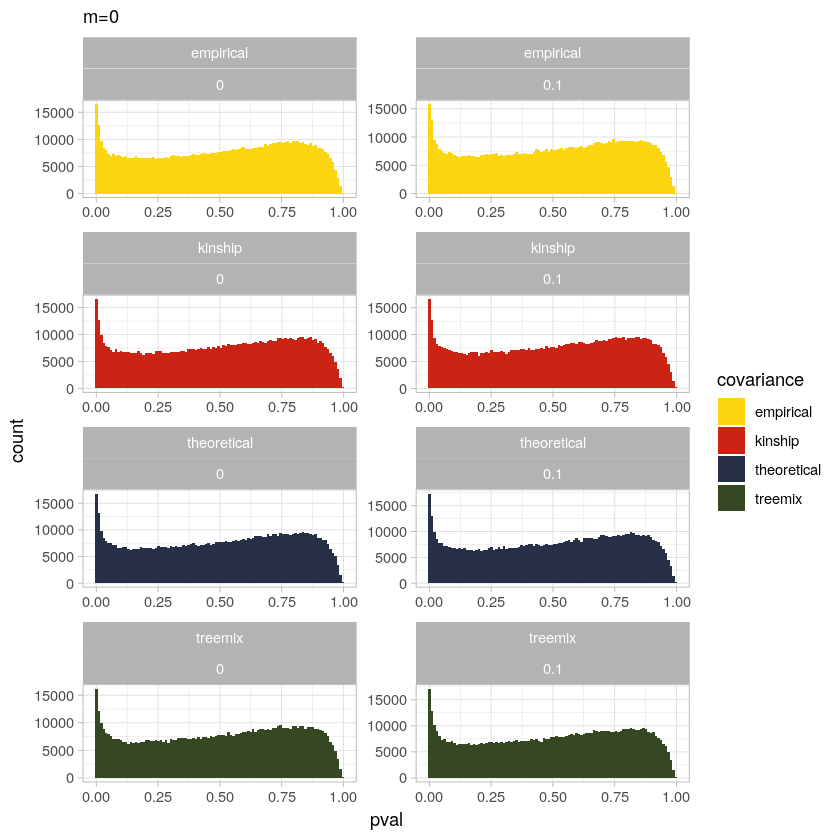

In [28]:
mcoef <- 0.0
hapflk %>% filter(m==mcoef) %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

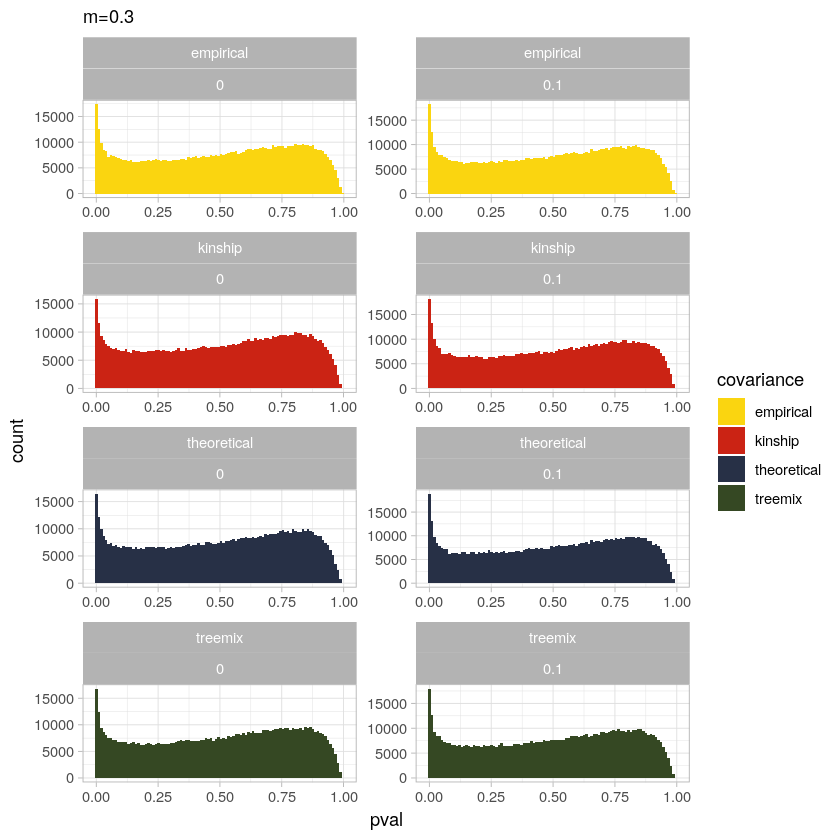

In [30]:
mcoef <- 0.3
hapflk %>% filter(m==mcoef) %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

Manhattan plots for selection

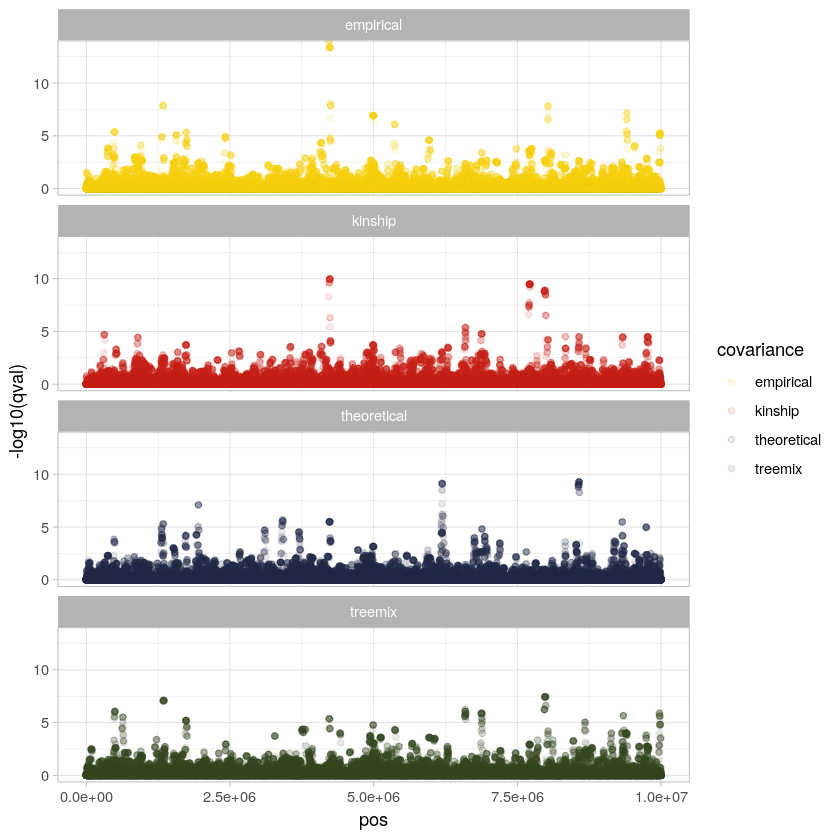

In [88]:
hapflk %>% filter(m==0) %>%
  filter(s==0.1) %>%
  ggplot(., aes(x=pos, y = -log10(qval))) +
  geom_point( aes(color=covariance), alpha = 0.1 ) +
  facet_wrap(~covariance, ncol = 1) +
  theme_light()+
  scale_color_manual(values = colors)

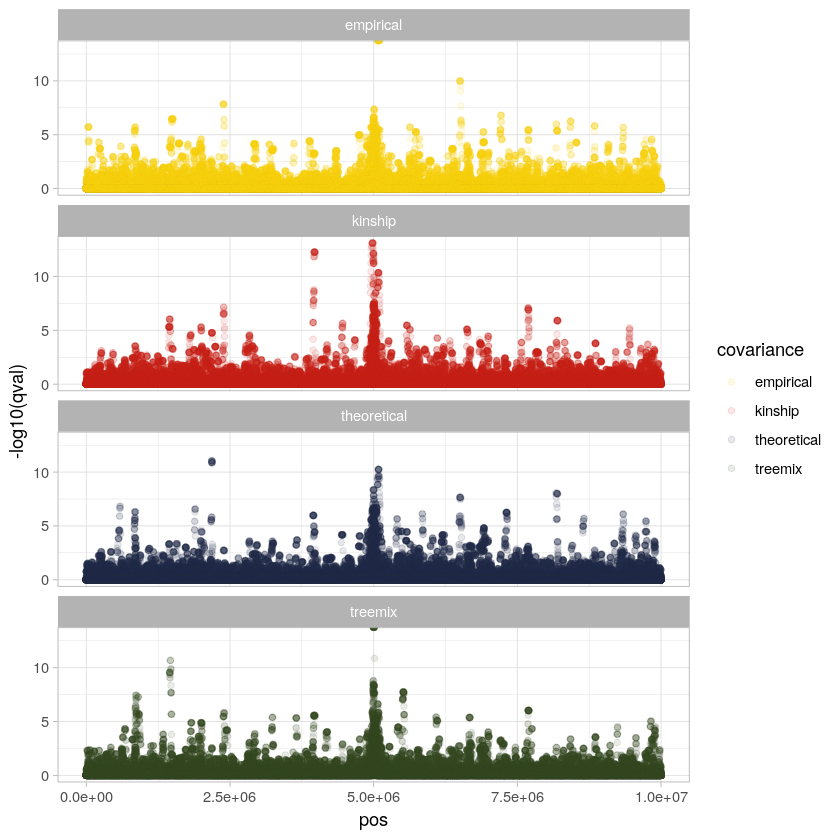

In [89]:
hapflk %>% filter(m==0.3) %>%
  filter(s==0.1) %>%
  ggplot(., aes(x=pos, y = -log10(qval))) +
  geom_point( aes(color=covariance), alpha = 0.1 ) +
  facet_wrap(~covariance, ncol = 1) +
  theme_light()+
  scale_color_manual(values = colors)

## Raw statistics Manhattan plots

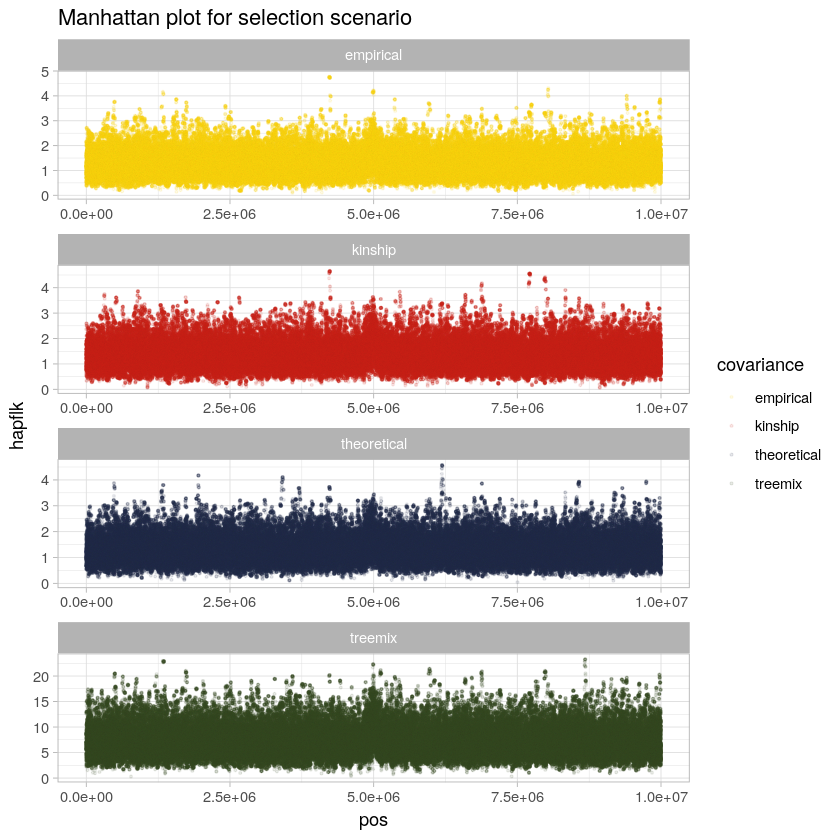

In [90]:
hapflk %>% filter(m==0) %>%
filter(s==0.1) %>%
    ggplot(aes(x=pos, y = hapflk, color = covariance)) +
    geom_point(size  = 0.5, alpha = 0.1) +
    facet_wrap(~covariance, ncol = 1, scales = "free") +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plot for selection scenario")

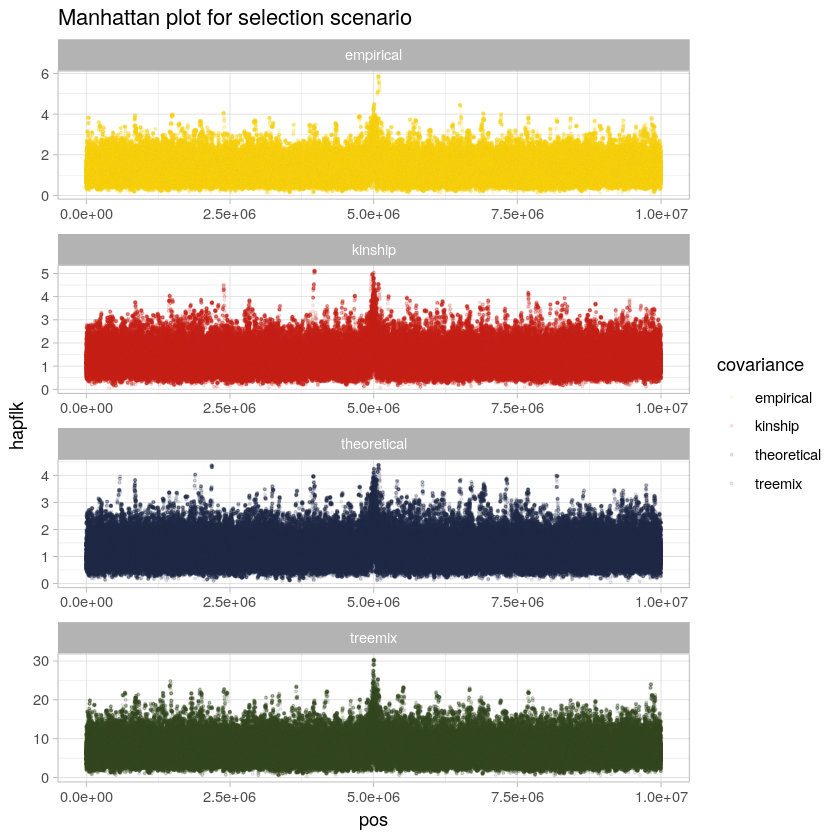

In [20]:
hapflk %>% filter(m==0.3) %>%
filter(s==0.1) %>%
    ggplot(aes(x=pos, y = hapflk, color = covariance)) +
    geom_point(size  = 0.5, alpha = 0.1) +
    facet_wrap(~covariance, ncol = 1, scales = "free") +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plot for selection scenario")

## Chi squared rescaling for hapFLK

hapFLK values will be rescaled with theoretical values (for given degrees of freedom (npop−1)(K−1) using quantile (robust) regression.

In [31]:
# function for computing scaled values
qReg <- function(x, probs = seq(0,1-0.01,0.01),df){
    # Compute empirical quantiles
    eq <- quantile(x, probs=probs)
    # Compute theoretical quantiles
    tq  <- qchisq(probs, df=df ) 
    # Fit a robust linear model
    fit  <- MASS::rlm(tq~eq, maxit=100)
    # Get coefficients
    b <- fit$coefficients[1]
    a <- fit$coefficients[2]
    # Return scaled values
    y_hat <- x*a + b
    return(y_hat)
}

In [32]:
hapflk <- hapflk %>%
    group_by(replicate, covariance, s,m) %>%
    rename(unscaled="hapflk") %>%
    mutate(scaled=qReg(unscaled, df = hapflk_df) ) %>%
    pivot_longer(cols = c("unscaled", "scaled"),
                 names_to = "scaling",
                 values_to = "hapflk" ) %>%
    group_by(replicate,covariance,scaling, s,m) %>%
    mutate(pval = 1- pchisq(hapflk, df = hapflk_df ) ) %>%
    mutate(qval = p.adjust(pval, method = "fdr" ) ) %>%
    ungroup()

In [33]:
hapflk

chr pos     flk       replicate covariance m   s   pval      qval     
1        1    3818    1.584112 9         treemix    0   0   0.9988292 1.0000000
2        1    3818    1.584112 9         treemix    0   0   0.7739833 0.9942284
3        1    6641   13.125145 9         treemix    0   0   0.9988287 1.0000000
4        1    6641   13.125145 9         treemix    0   0   0.7739274 0.9942284
5        1    6842   25.285345 9         treemix    0   0   0.9985592 1.0000000
6        1    6842   25.285345 9         treemix    0   0   0.7478883 0.9942284
7        1    8696   12.668436 9         treemix    0   0   0.9985409 1.0000000
8        1    8696   12.668436 9         treemix    0   0   0.7462287 0.9942284
9        1    9433   12.955504 9         treemix    0   0   0.9985409 1.0000000
10       1    9433   12.955504 9         treemix    0   0   0.7462280 0.9942284
11       1   11923   25.288429 9         treemix    0   0   0.9773625 1.0000000
12       1   11923   25.288429 9         treemix    0   0   0.2562114 0.9754036
13       1   16324   27.365015 9         treemix    0   0   0.9773624 1.0000000
14       1   16324   27.365015 9         treemix    0   0   0.2562100 0.9754036
15       1   17997   11.387609 9         treemix    0   0   0.9764847 1.0000000
16       1   17997   11.387609 9         treemix    0   0   0.2491863 0.9740967
17       1   18193   16.658178 9         treemix    0   0   0.9764846 1.0000000
18       1   18193   16.658178 9         treemix    0   0   0.2491858 0.9740967
19       1   18829   10.754239 9         treemix    0   0   0.9764827 1.0000000
20       1   18829   10.754239 9         treemix    0   0   0.2491707 0.9740967
21       1   19200    3.757574 9         treemix    0   0   0.9760525 1.0000000
22       1   19200    3.757574 9         treemix    0   0   0.2458446 0.9740103
23       1   20364    9.465695 9         treemix    0   0   0.9665768 1.0000000
24       1   20364    9.465695 9         treemix    0   0   0.1874828 0.9730451
25       1   20886          NA 9         treemix    0   0   0.9665767 1.0000000
26       1   20886          NA 9         treemix    0   0   0.1874824 0.9730451
27       1   21266    5.559144 9         treemix    0   0   0.9665766 1.0000000
28       1   21266    5.559144 9         treemix    0   0   0.1874819 0.9730451
29       1   25486   19.846917 9         treemix    0   0   0.9665652 1.0000000
30       1   25486   19.846917 9         treemix    0   0   0.1874253 0.9730451
⋮        ⋮   ⋮       ⋮         ⋮         ⋮          ⋮   ⋮   ⋮         ⋮        
24622371 1   9976534 1.5455123 100       empirical  0.3 0.1 0.9999999 1.0000000
24622372 1   9976534 1.5455123 100       empirical  0.3 0.1 0.3382478 0.9890324
24622373 1   9977535 1.5455123 100       empirical  0.3 0.1 0.9999999 1.0000000
24622374 1   9977535 1.5455123 100       empirical  0.3 0.1 0.3377950 0.9890324
24622375 1   9978015 1.5455123 100       empirical  0.3 0.1 0.9999999 1.0000000
24622376 1   9978015 1.5455123 100       empirical  0.3 0.1 0.3373433 0.9890324
24622377 1   9982211 7.4124849 100       empirical  0.3 0.1 0.9999999 1.0000000
24622378 1   9982211 7.4124849 100       empirical  0.3 0.1 0.3065723 0.9792784
24622379 1   9982219 7.4124849 100       empirical  0.3 0.1 0.9999999 1.0000000
24622380 1   9982219 7.4124849 100       empirical  0.3 0.1 0.3065722 0.9792784
24622381 1   9983280        NA 100       empirical  0.3 0.1 0.9999999 1.0000000
24622382 1   9983280        NA 100       empirical  0.3 0.1 0.3126351 0.9792784
24622383 1   9984664 7.3355821 100       empirical  0.3 0.1 0.9999999 1.0000000
24622384 1   9984664 7.3355821 100       empirical  0.3 0.1 0.3144996 0.9792784
24622385 1   9986109 3.2944038 100       empirical  0.3 0.1 0.9999999 1.0000000
24622386 1   9986109 3.2944038 100       empirical  0.3 0.1 0.3145000 0.9792784
24622387 1   9990668 0.2812987 100       empirical  0.3 0.1 0.9999999 1.0000000
24622388 1   9990668 0.2812987 100       empirical  0.3 0.1 0.3177711 0.9808639
24622389 

Let's compare the rescaled density estimates with unscaled estimates, together with the theoretical chi-squared distribution.

For no migration:

Warning message:
“Removed 29776 rows containing non-finite values (stat_density).”


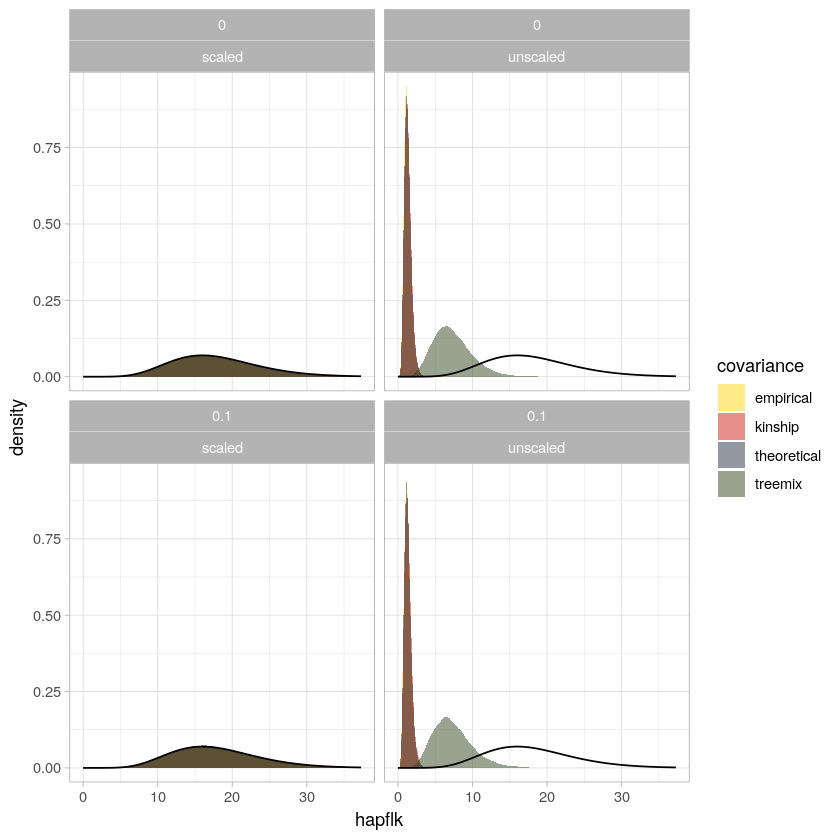

In [94]:
hapflk %>% filter(m==0) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    stat_function(fun = dchisq, args = list(df=hapflk_df)) +
    xlim(0,max(rchisq(n=100,df=hapflk_df))) +
    facet_wrap(~s+scaling) +
    theme_light() +
    scale_fill_manual(values = colors)

For migration:

Warning message:
“Removed 79628 rows containing non-finite values (stat_density).”


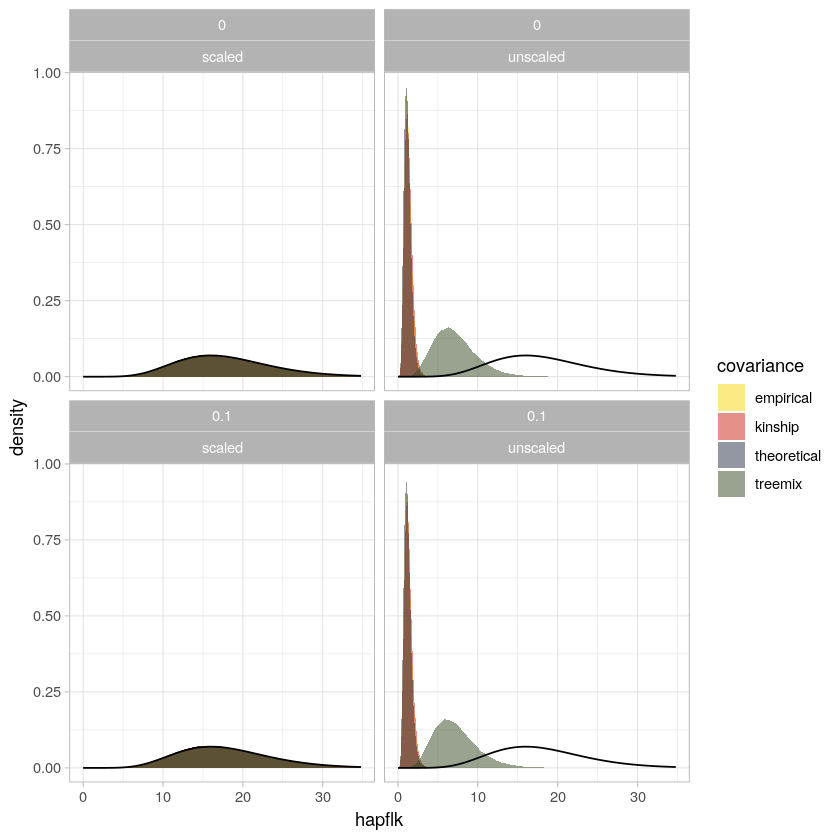

In [95]:
hapflk %>% filter(m==0.3) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    stat_function(fun = dchisq, args = list(df=hapflk_df)) +
    xlim(0,max(rchisq(n=100,df=hapflk_df))) +
    facet_wrap(~s+scaling) +
    theme_light() +
    scale_fill_manual(values = colors)

Scaling seems to work pretty well, lets draw p-value histograms and manhattan plots to see if everything behaves as expected

p-value histograms for m=0

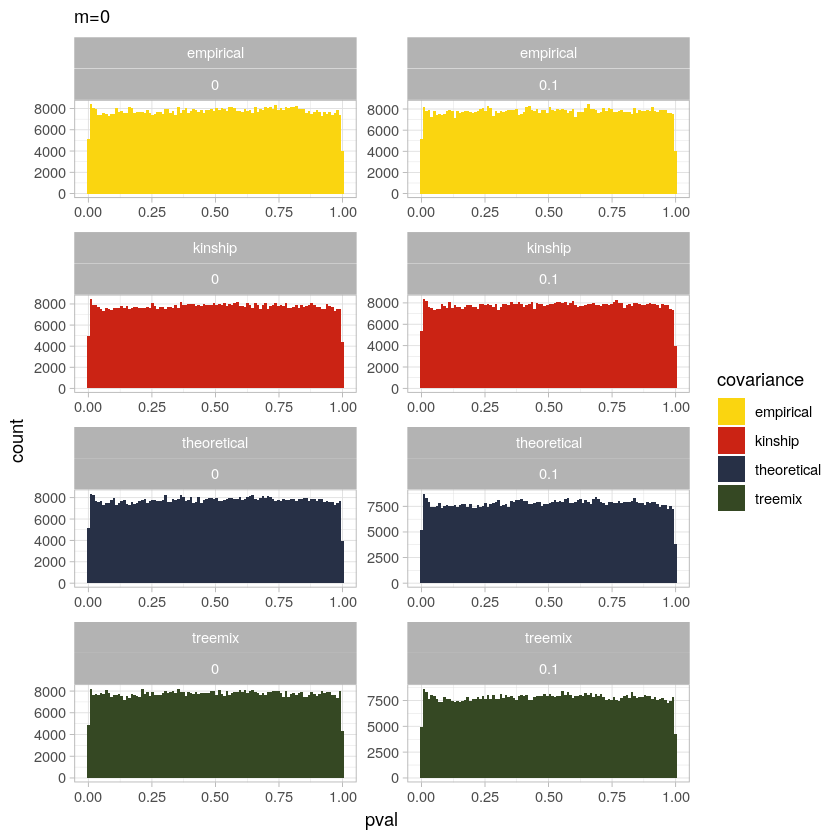

In [34]:
mcoef <- 0.0
hapflk %>% filter(m==mcoef) %>%
            filter(scaling=="scaled") %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

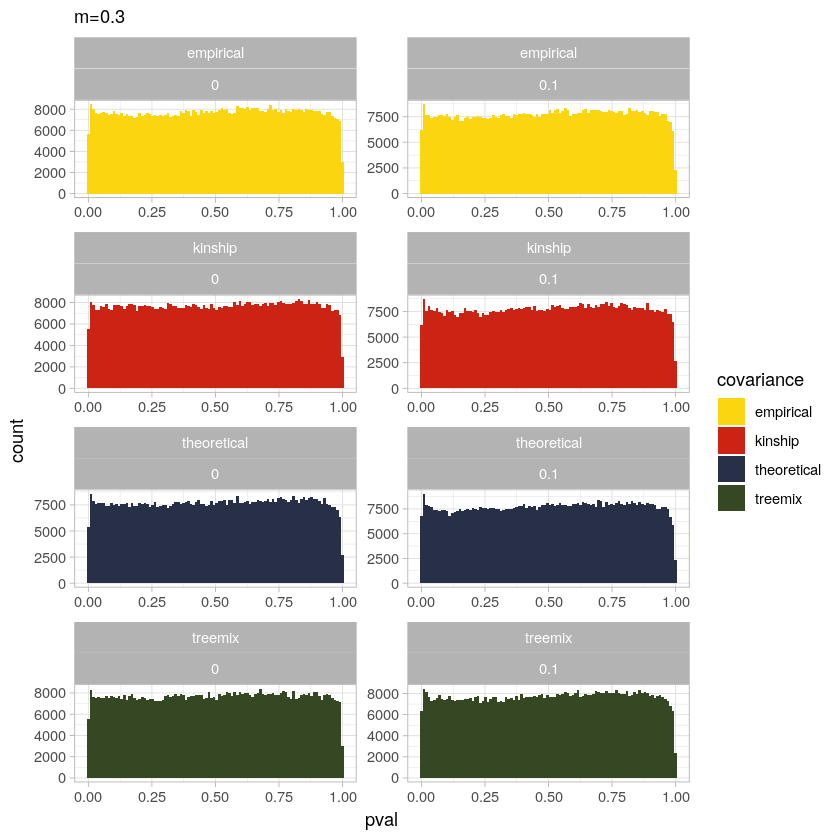

In [35]:
mcoef <- 0.3
hapflk %>% filter(m==mcoef) %>%
            filter(scaling=="scaled") %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



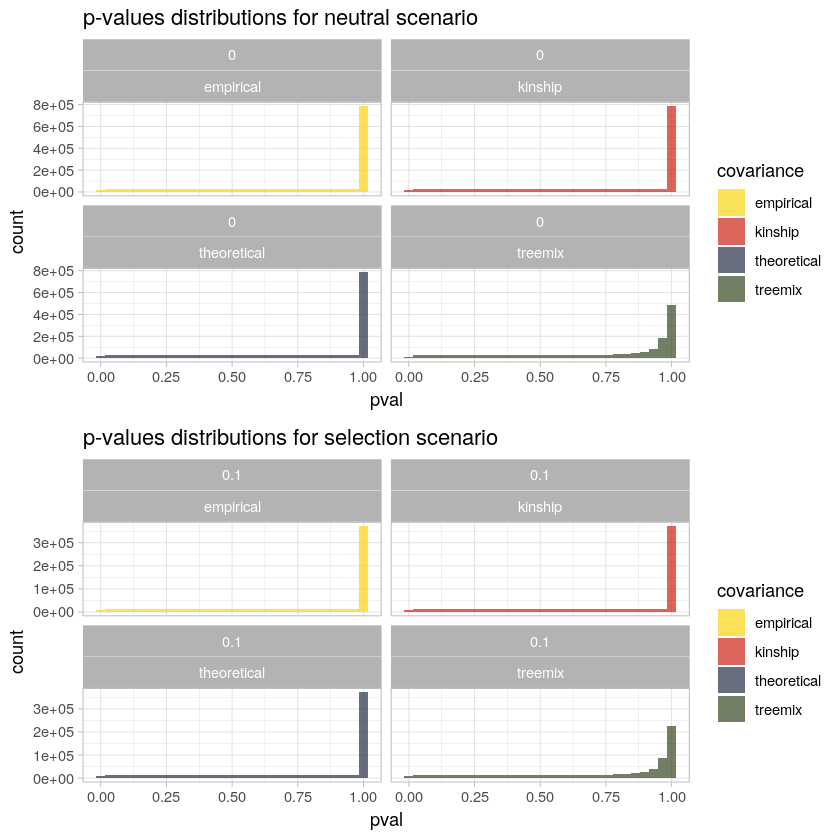

In [96]:
s_1 <- hapflk %>% filter(s==0,m==0) %>%
        ggplot(aes(x=pval, fill = covariance)) +
        geom_histogram(alpha=0.7) +
        facet_wrap(~s+covariance, ncol = 2) +
        scale_fill_manual(values = colors) +
        theme_light() +
        ggtitle("p-values distributions for neutral scenario")
s_2 <- hapflk %>% filter(s==0.1,m==0) %>%
        ggplot(aes(x=pval, fill = covariance)) +
        geom_histogram(alpha=0.7) +
        facet_wrap(~s+covariance, ncol = 2) +
        scale_fill_manual(values = colors) +
        theme_light() +
        ggtitle("p-values distributions for selection scenario")
grid.arrange(s_1,s_2)

p-value histograms for m=0.3

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



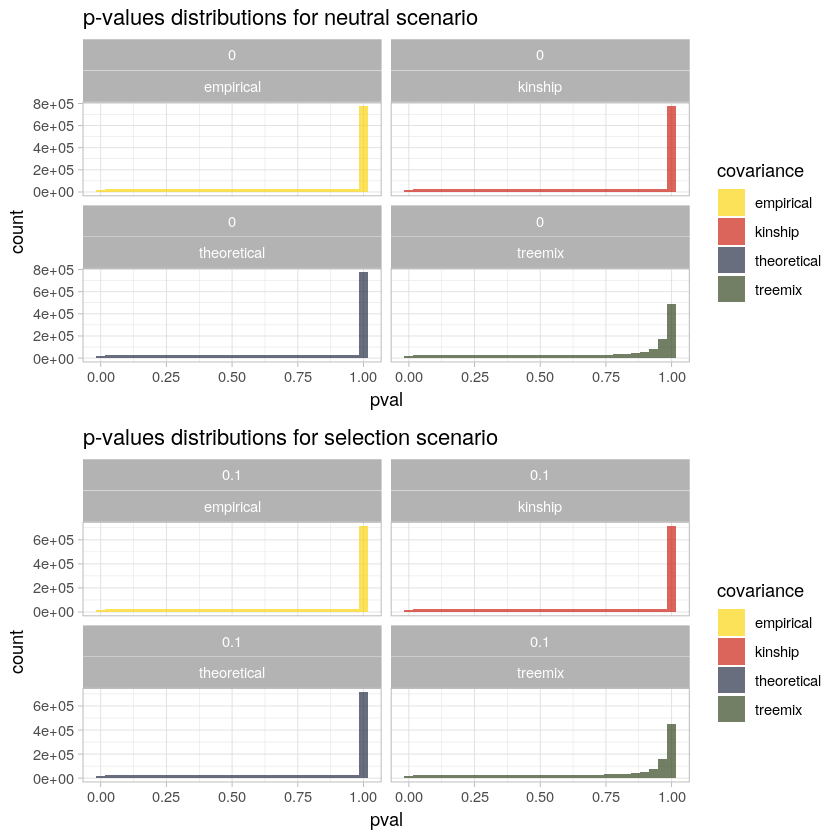

In [97]:
s_1 <- hapflk %>% filter(s==0,m==0.3) %>%
        ggplot(aes(x=pval, fill = covariance)) +
        geom_histogram(alpha=0.7) +
        facet_wrap(~s+covariance, ncol = 2) +
        scale_fill_manual(values = colors) +
        theme_light() +
        ggtitle("p-values distributions for neutral scenario")
s_2 <- hapflk %>% filter(s==0.1,m==0.3) %>%
        ggplot(aes(x=pval, fill = covariance)) +
        geom_histogram(alpha=0.7) +
        facet_wrap(~s+covariance, ncol = 2) +
        scale_fill_manual(values = colors) +
        theme_light() +
        ggtitle("p-values distributions for selection scenario")
grid.arrange(s_1,s_2)

Manhattan plots for m=0

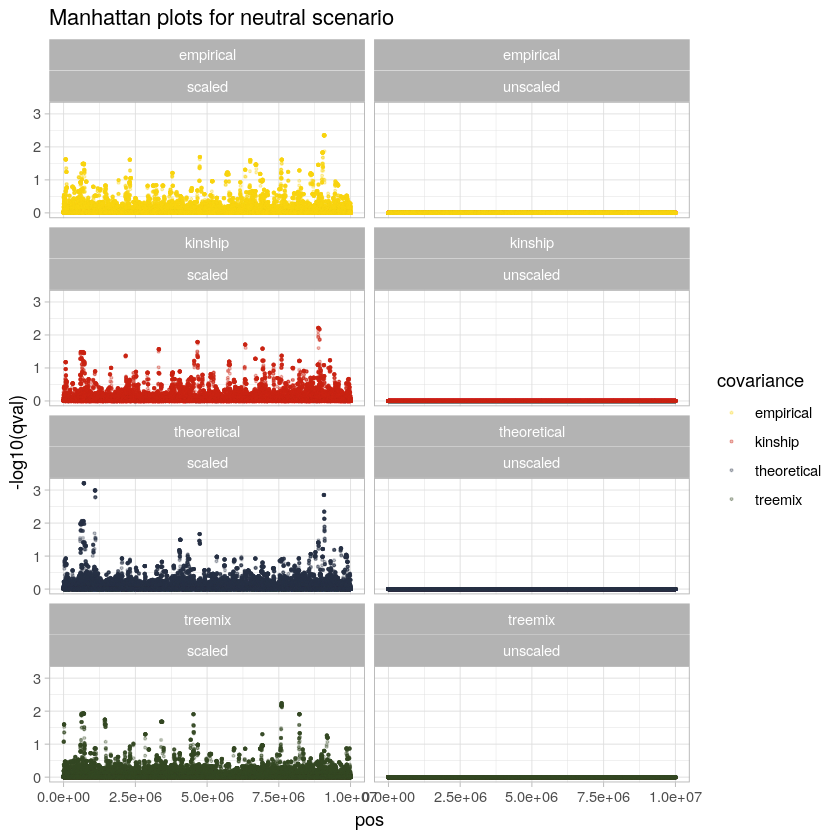

In [98]:
hapflk %>% filter(m==0&s==0) %>%   
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for neutral scenario")

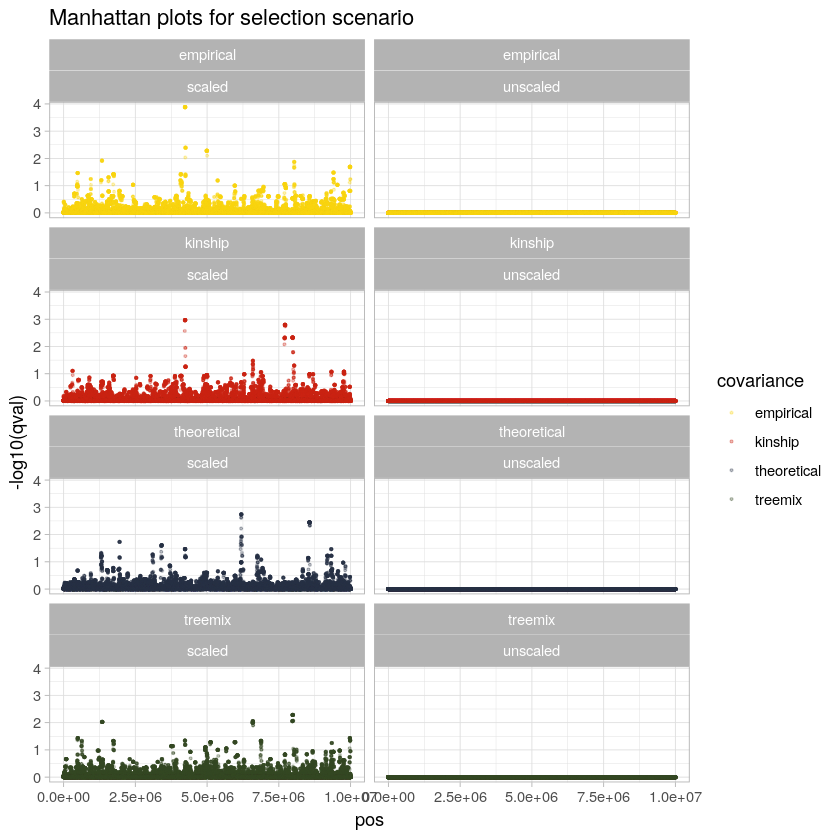

In [99]:
hapflk %>% filter(m==0&s==0.1) %>%   
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for selection scenario")

Manhattan plots for m=0.3

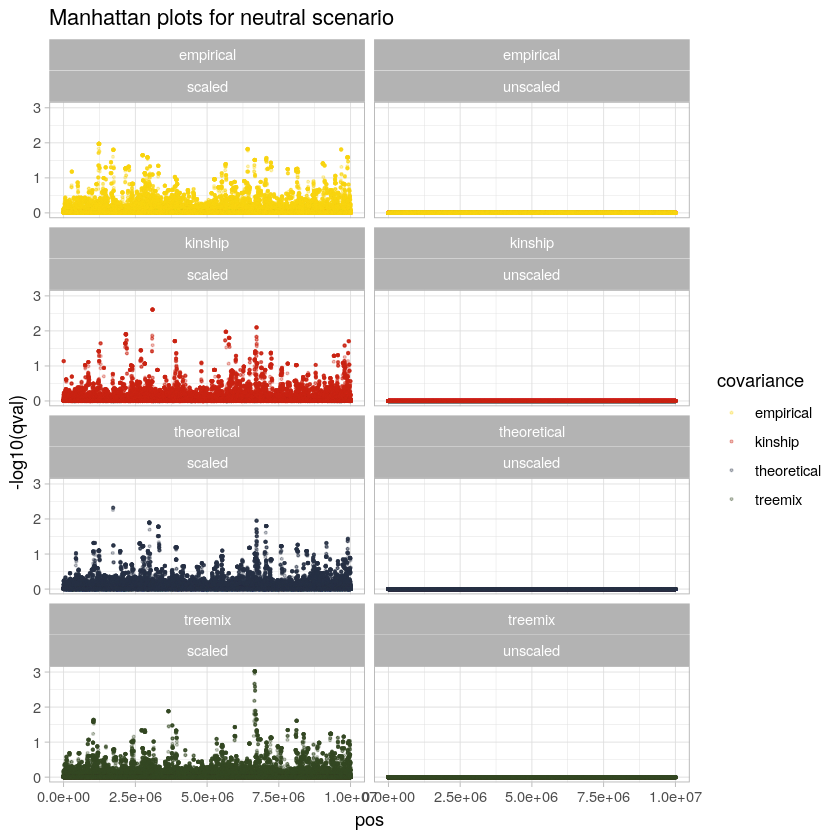

In [100]:
hapflk %>% filter(m==0.3&s==0) %>%   
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for neutral scenario")

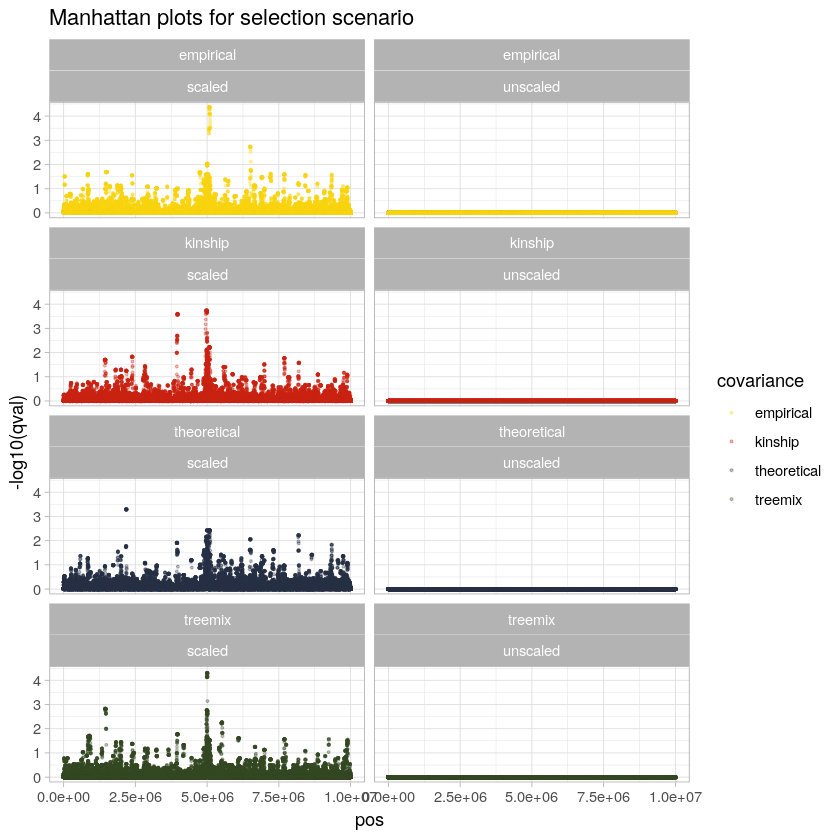

In [101]:
hapflk %>% filter(m==0.3&s==0.1) %>%   
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for selection scenario")

## Normal robust rescaling of hapFLK values

In [102]:
# Define scaling function
normalScaling <- function( x ){
    
    # Compute robust estimates of mean and sd
    fit <- MASS::rlm(x~1)
    mu <- fit$coefficients[1]
    s <- fit$s
    y_hat <- (x - mu) / s
    return(y_hat)
    
}

In [103]:
# Wrangle for removing chi squared statistics

hapflk <- hapflk %>% dplyr::select(-qval,-pval) %>%
        filter(scaling == "unscaled" ) %>%
        pivot_wider(names_from="scaling", values_from = "hapflk")

In [104]:
# Compute p values
hapflk <- hapflk %>%
    group_by(replicate, covariance, s,m) %>%
    mutate(scaled=normalScaling(unscaled) ) %>%
    pivot_longer(cols = c("unscaled", "scaled"),
                 names_to = "scaling",
                 values_to = "hapflk" ) %>%
    group_by(replicate,covariance,scaling,s,m) %>%
    mutate(pval = 1- pnorm(hapflk,
                           mean=MASS::rlm(hapflk~1)$coefficients[1],
                           sd = MASS::rlm(hapflk~1)$s ) ) %>%
    mutate(qval = p.adjust(pval, method = "fdr" ) ) 

We should visualize and compared the computed scaled densities with unscaled densities.

First, m=0

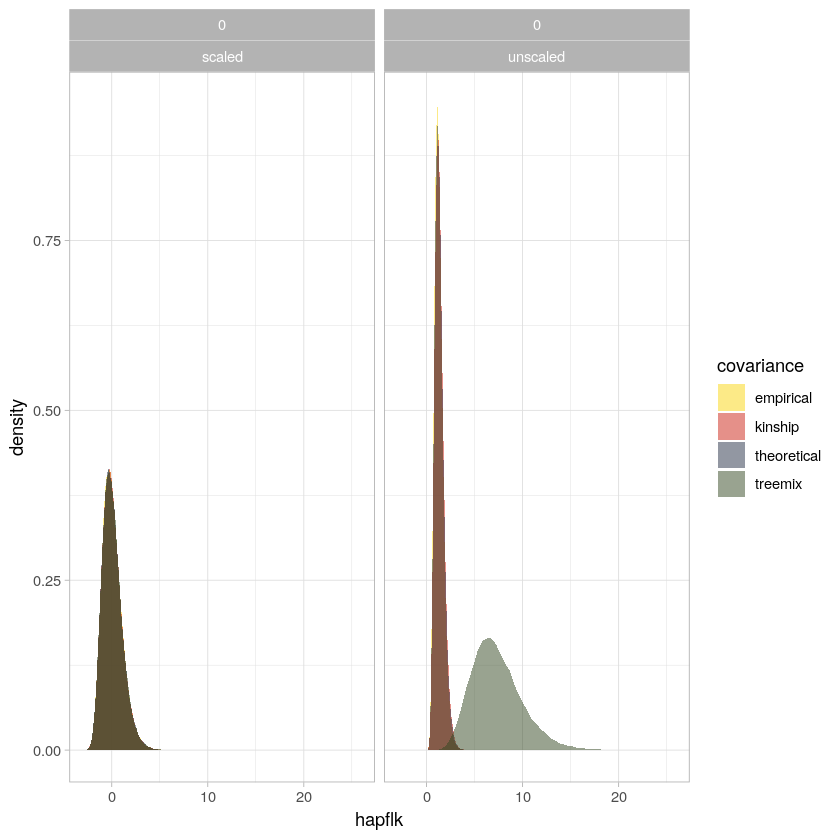

In [105]:
hapflk %>% filter(m==0&s==0) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    facet_wrap(~s+scaling) +
    theme_light() +
    scale_fill_manual(values = colors)

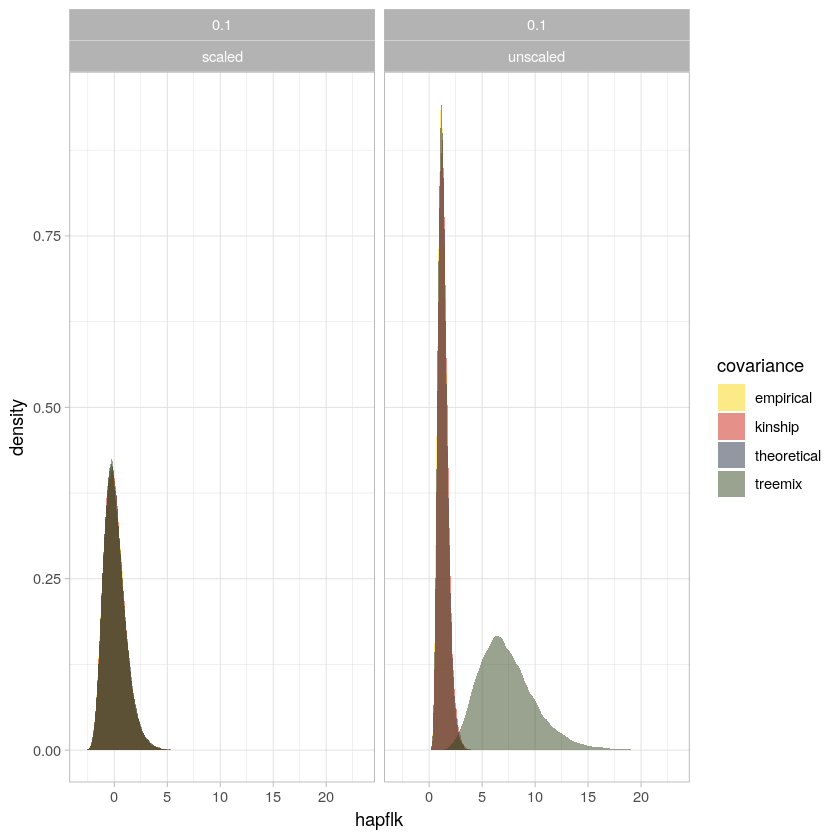

In [106]:
hapflk %>% filter(m==0&s==0.1) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    facet_wrap(~s+scaling) +
    theme_light() +
    scale_fill_manual(values = colors)

Now, m=0.1

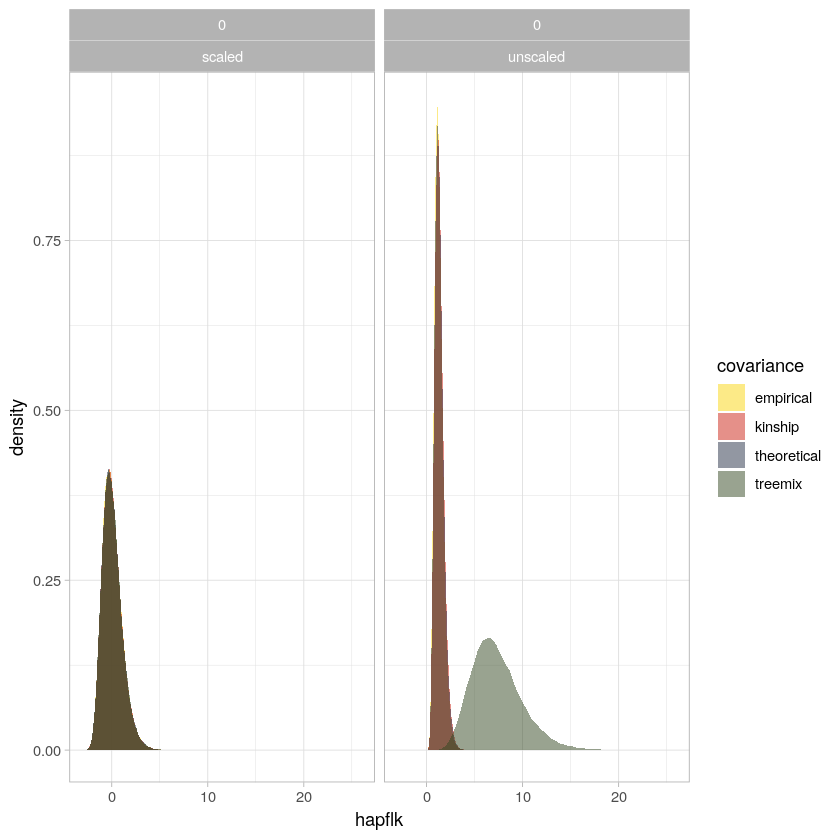

In [107]:
hapflk %>% filter(m==0&s==0) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    facet_wrap(~s+scaling) +
    theme_light() +
    scale_fill_manual(values = colors)

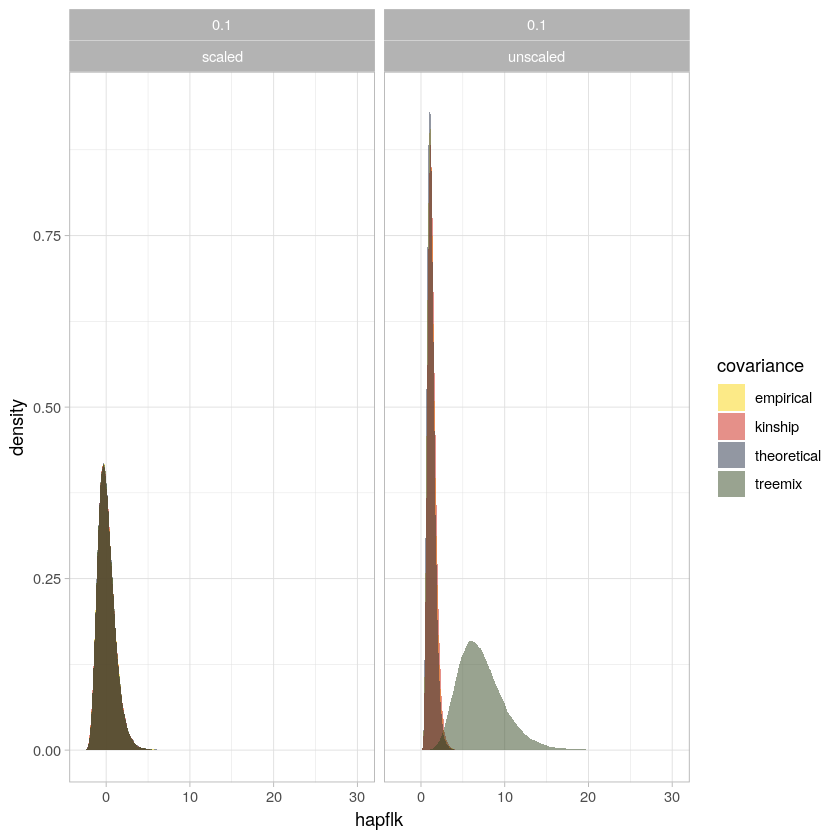

In [108]:
hapflk %>% filter(m==0.3&s==0.1) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    facet_wrap(~s+scaling) +
    theme_light() +
    scale_fill_manual(values = colors)

What about p-value distributions?

For m=0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



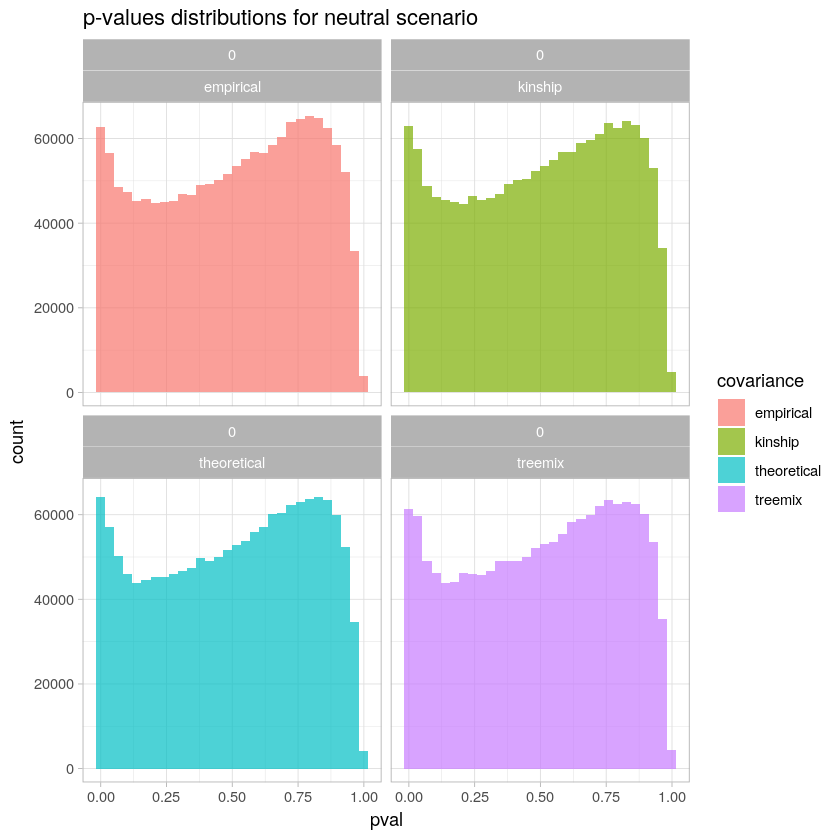

In [109]:
hapflk %>% filter(m==0&s==0) %>%
    ggplot(aes(x=pval, fill = covariance)) +
    geom_histogram(alpha=0.7) +
    facet_wrap(~s+covariance, ncol = 2) +
    scale_color_manual(values = colors) +
    theme_light() +
    ggtitle("p-values distributions for neutral scenario")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



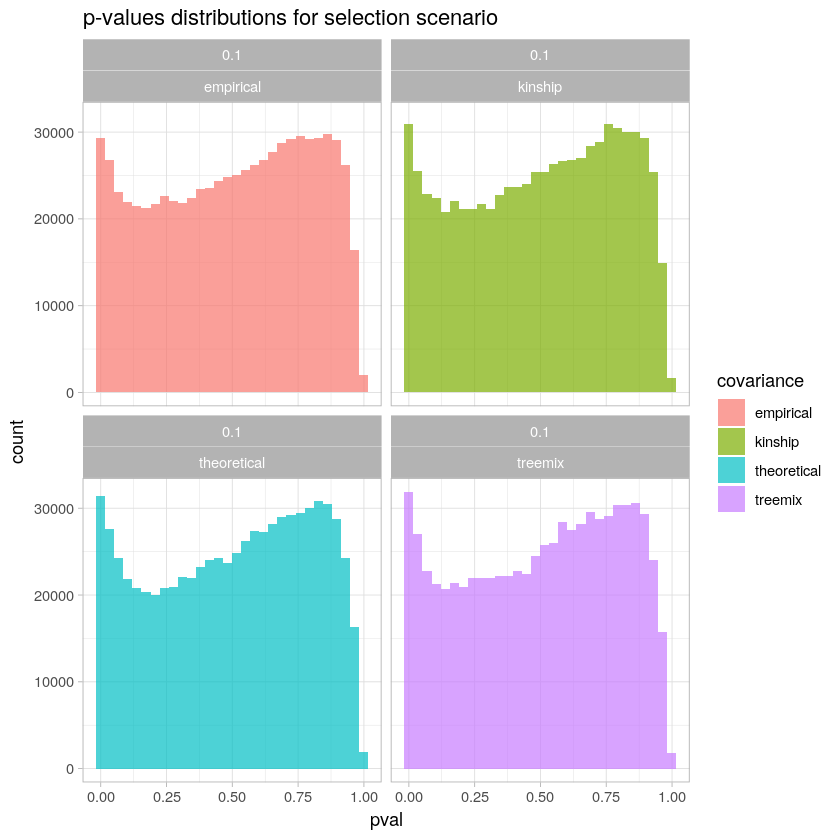

In [110]:
hapflk %>% filter(m==0&s==0.1) %>%
    ggplot(aes(x=pval, fill = covariance)) +
    geom_histogram(alpha=0.7) +
    facet_wrap(~s+covariance, ncol = 2) +
    scale_color_manual(values = colors) +
    theme_light() +
    ggtitle("p-values distributions for selection scenario")

For m=0.3

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



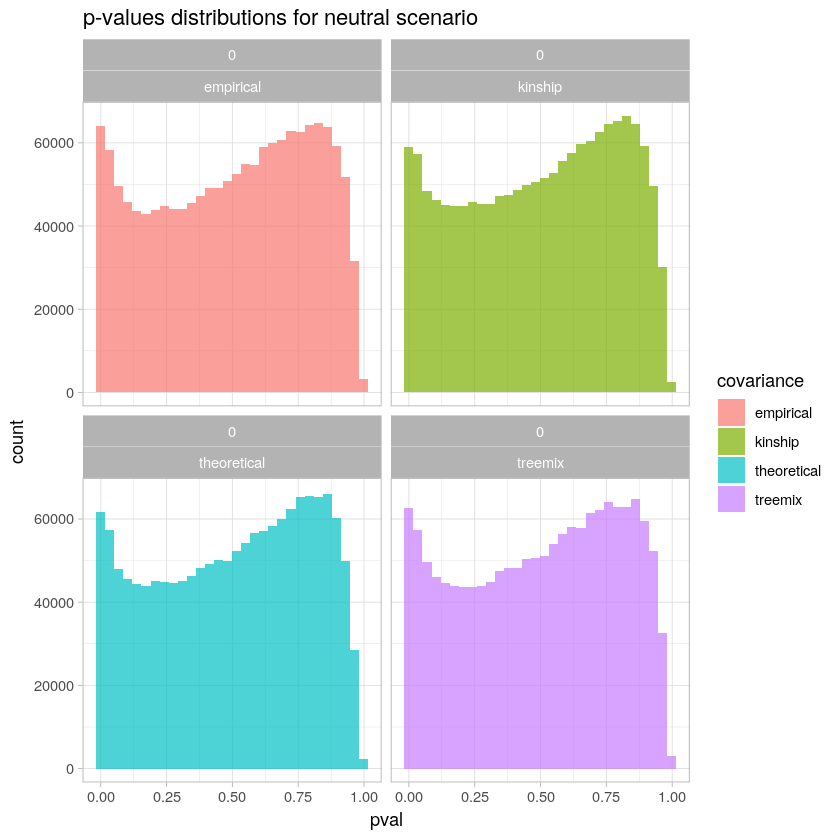

In [111]:
hapflk %>% filter(m==0.3&s==0) %>%
    ggplot(aes(x=pval, fill = covariance)) +
    geom_histogram(alpha=0.7) +
    facet_wrap(~s+covariance, ncol = 2) +
    scale_color_manual(values = colors) +
    theme_light() +
    ggtitle("p-values distributions for neutral scenario")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



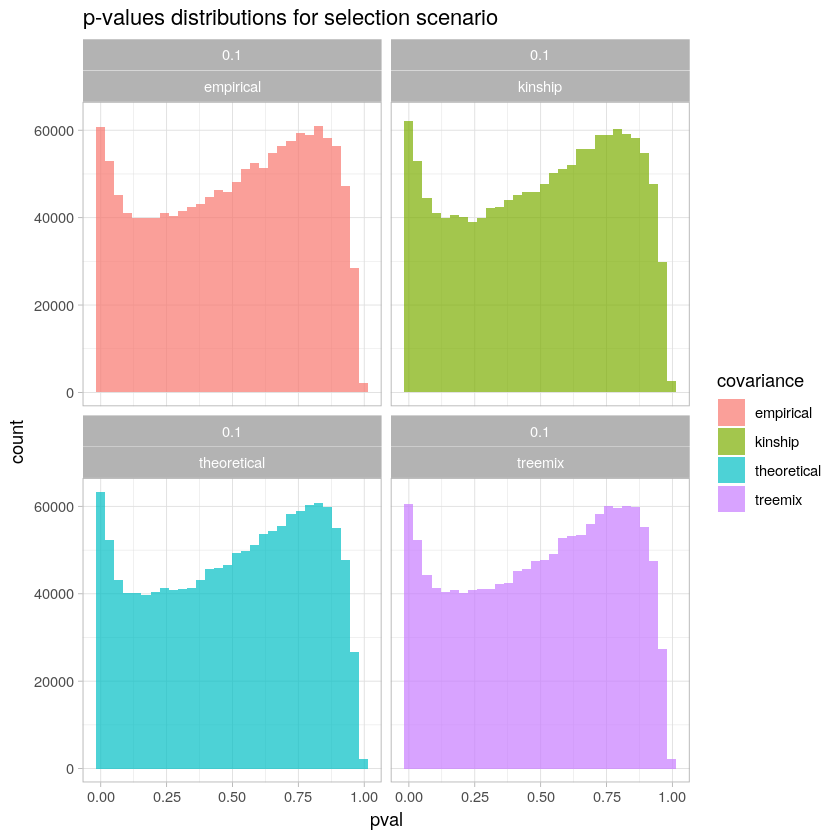

In [112]:
hapflk %>% filter(m==0.3&s==0.1) %>%
    ggplot(aes(x=pval, fill = covariance)) +
    geom_histogram(alpha=0.7) +
    facet_wrap(~s+covariance, ncol = 2) +
    scale_color_manual(values = colors) +
    theme_light() +
    ggtitle("p-values distributions for selection scenario")

And now, for everyone's delight, Manhtattan plots!

For m=0

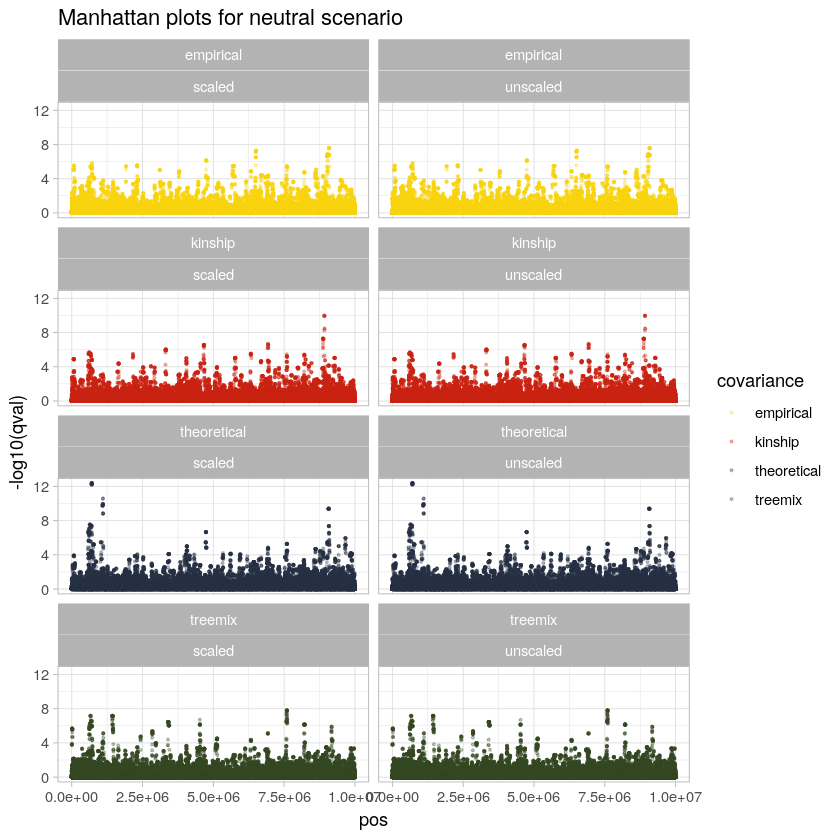

In [113]:
hapflk %>% filter(m==0&s==0) %>%
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for neutral scenario")

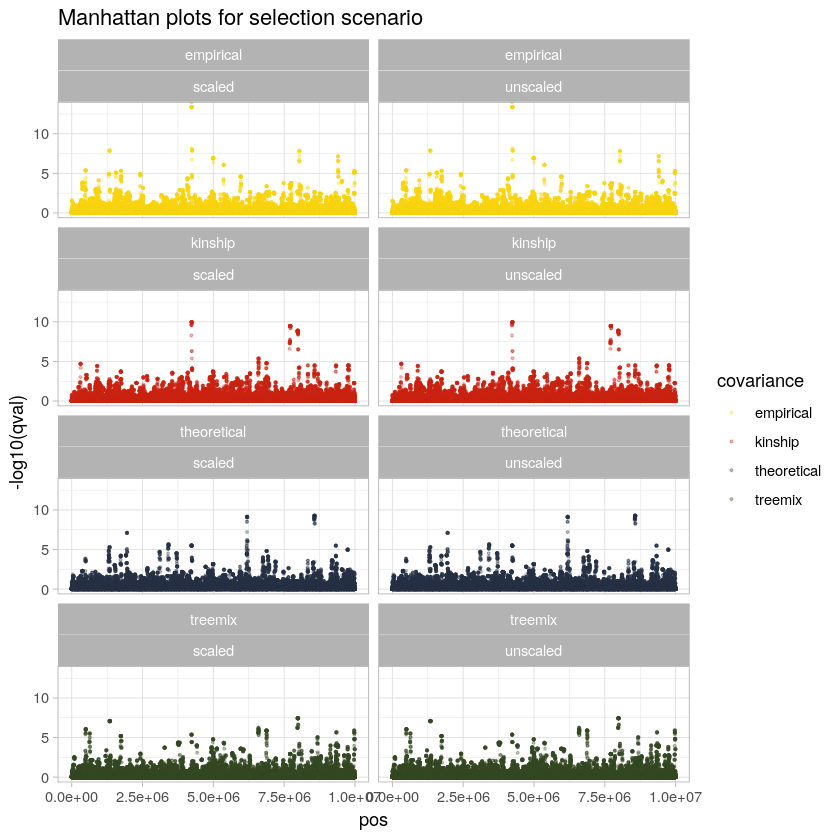

In [114]:
hapflk %>% filter(m==0&s==0.1) %>%
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for selection scenario")

For m=0.3

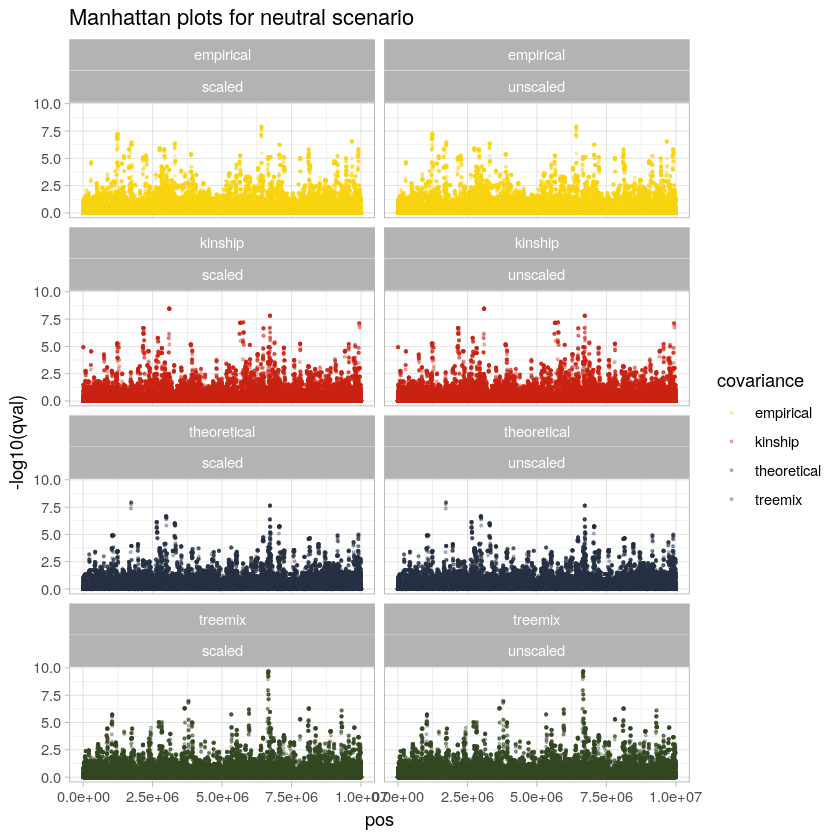

In [115]:
hapflk %>% filter(m==0.3&s==0) %>%
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for neutral scenario")

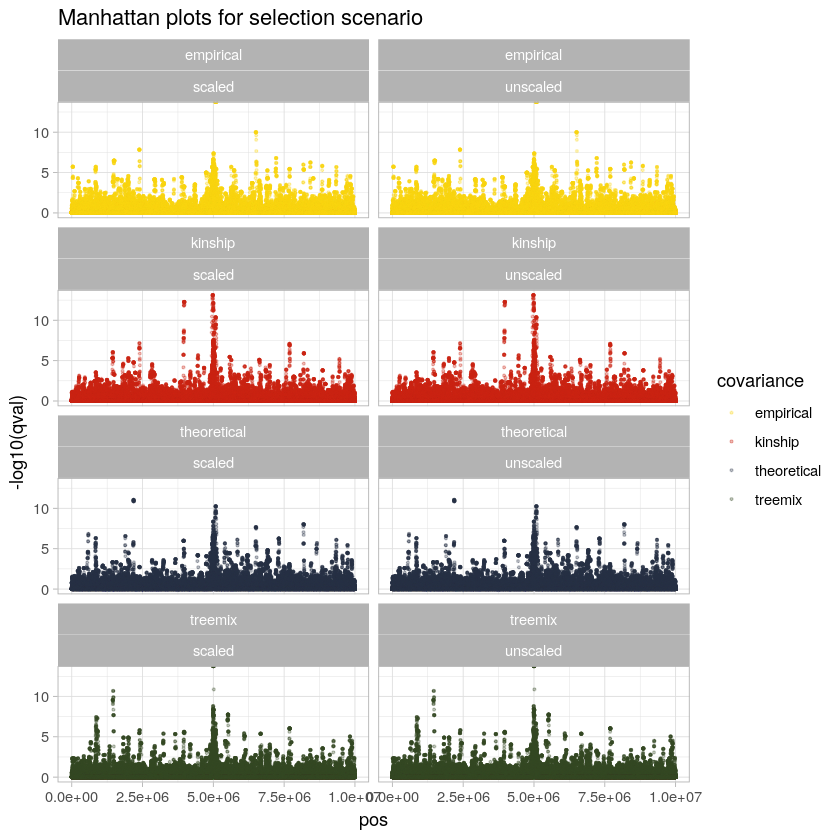

In [116]:
hapflk %>% filter(m==0.3&s==0.1) %>%
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for selection scenario")

## Power analysis

Deine functions for power analysis and plotting

In [117]:
computePower <- function( quantile, null, empirical ){
    null <- rev(null)
    sum(empirical > null[quantile] ) / length(empirical)
}

In [118]:
computeROC <- function( input_df, mcoef ){
    
    max_stats<- input_df %>% 
        filter(m==mcoef) %>%
        group_by( replicate, covariance, s ) %>%
        summarise(Smax=max(hapflk))
    # Define global variables
    null_global <- max_stats %>% filter(s==0) 
    selection_global <- max_stats %>% filter(s!=0) 
    alpha <- seq(0,1,0.01)
    quantiles <- 1:length(alpha)
    # Allocate dataframe
    
    df <- data.frame(alpha) %>% as_tibble()
    # Define groupings
    covariances <- max_stats %>%
        dplyr::select(covariance) %>%
        distinct() %>%
        pull(covariance)
    
    
    for ( i in covariances ){
        
        null <- null_global %>%
            filter(covariance == i ) %>%
            pull(Smax)
        selection <- selection_global %>%
            filter(covariance == i ) %>%
            pull(Smax)
        
        qnull <- quantile(null, probs = alpha )
        power <- sapply(quantiles,
                        FUN = computePower,
                        empirical = selection,
                        null = qnull )
        
        df[i] <- power
        
    }
    
    
    df <- df %>%
        pivot_longer(cols = all_of(covariances),
                     names_to = "covariance",
                     values_to = "power"
        )
    
    return(df)
    
}

In [119]:
plotROC <- function(df, mcoef){
    
    auc <- df %>%
        group_by(covariance) %>% 
        summarise(AUC=sum(power)) %>%
        arrange(desc(AUC))
    df %>%
        ggplot( aes(x=alpha, y = power) ) +
        geom_path(aes(color = covariance), size=2, alpha = 0.7) +
        geom_abline(slope = 1, intercept = 0, linetype="dashed", 
                    color="black", size=0.3) +
        theme_light()  +
        xlab("Type I Error") +
        ylab("Power") +
        labs(subtitle = paste0("m=",mcoef)) +
        scale_color_manual(values=colors) +
        annotation_custom(tableGrob(auc, rows = NULL),
                          ymax = 0.2,
                          ymin= 0.2,
                          xmax=0.8,
                          xmin=0.8
                          
                          )
        
        
}


Plot ROCs for m=0

In [120]:
roc <- computeROC(hapflk, 0)

`summarise()` has grouped output by 'replicate', 'covariance'. You can override using the `.groups` argument.

Adding missing grouping variables: `replicate`



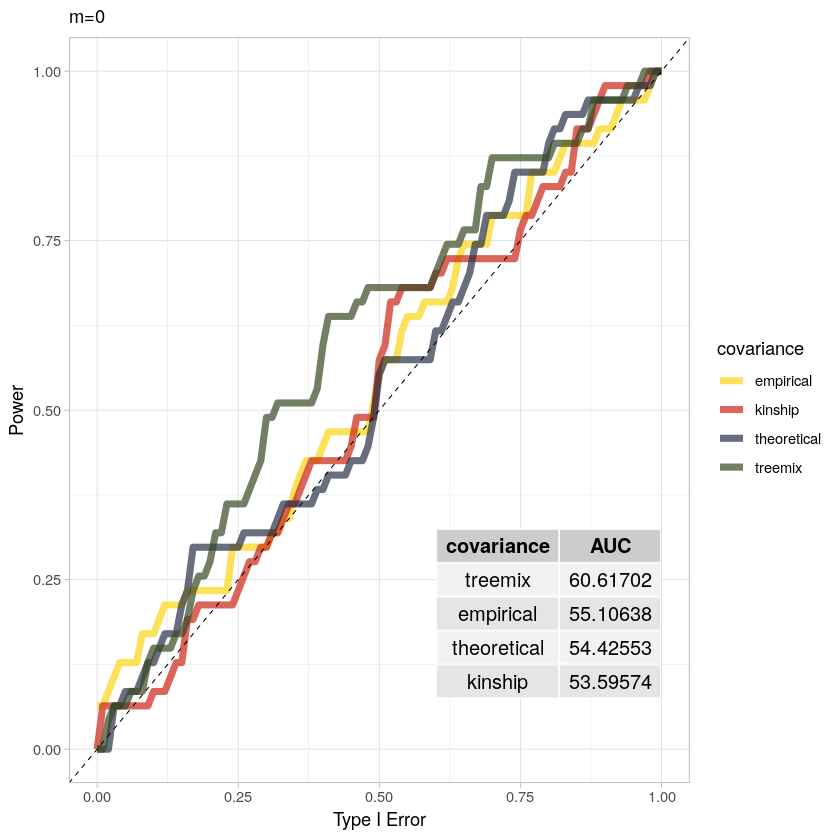

In [121]:
plotROC(roc,0)

Plot ROCs for m=0.3

In [122]:
roc <- computeROC(hapflk, 0.3)

`summarise()` has grouped output by 'replicate', 'covariance'. You can override using the `.groups` argument.

Adding missing grouping variables: `replicate`



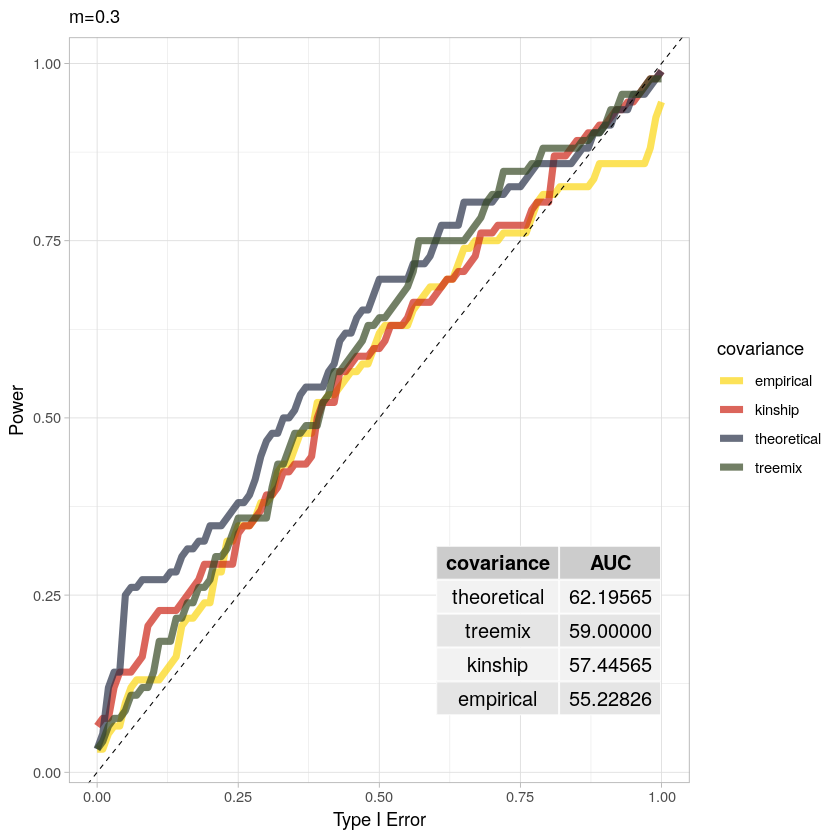

In [123]:
plotROC(roc,0.3)

# Looking into anomalies

In [124]:
head(hapflk)

replicate s m chr pos  flk      covariance scaling  hapflk     pval     
1 100       0 0 1    209 9.796548 treemix    unscaled  5.8150085 0.5947118
2 100       0 0 1    209 9.796548 treemix    scaled   -0.2396825 0.5947118
3 100       0 0 1   3039 8.697087 treemix    unscaled  5.8163548 0.5944719
4 100       0 0 1   3039 8.697087 treemix    scaled   -0.2390636 0.5944719
5 100       0 0 1   6102 6.573340 treemix    unscaled  5.8163910 0.5944654
6 100       0 0 1   6102 6.573340 treemix    scaled   -0.2390470 0.5944654
  qval     
1 0.9583437
2 0.9583437
3 0.9583437
4 0.9583437
5 0.9583437
6 0.9583437

## Treemix vs others


I wanna see whats the relationship between treemix estimated hapflk values and the other covariance matrices. To do this, I will do scatterplots and linear regressions of treemix vs all of the other hapflk values. If it is a matter of scale, then treemix will have a linear relationship with the other statistics.

In [38]:
hapWIDE <- hapflk %>% select(-flk) %>%
pivot_wider(names_from = covariance, values_from = hapflk) 

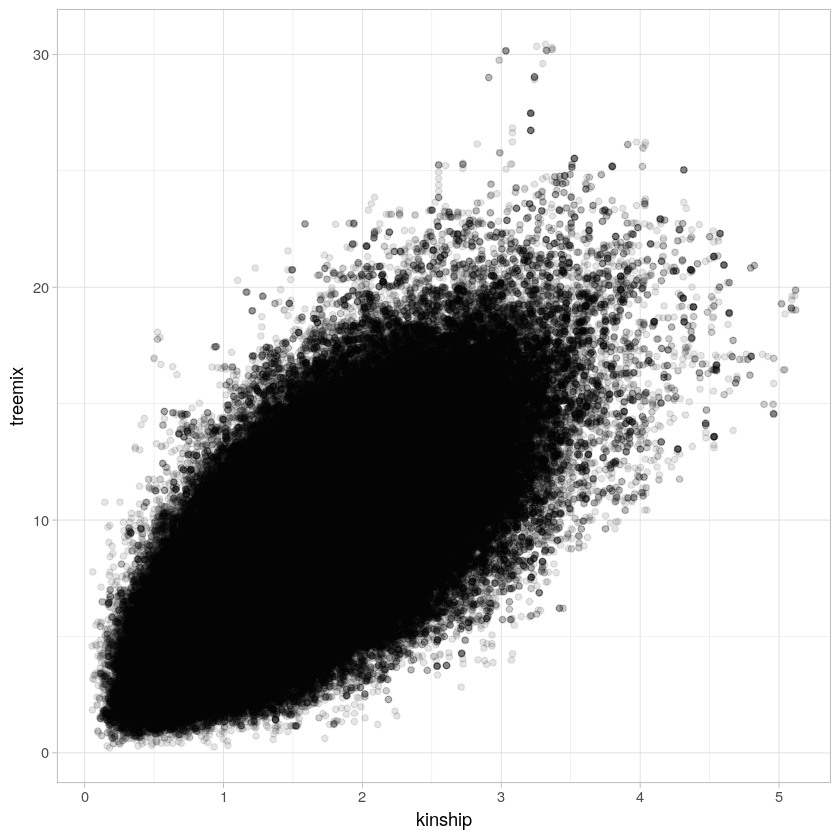

In [40]:
hapWIDE %>% ggplot(aes(x=kinship,y=treemix)) +
    theme_light() +
    geom_point(alpha=0.1)

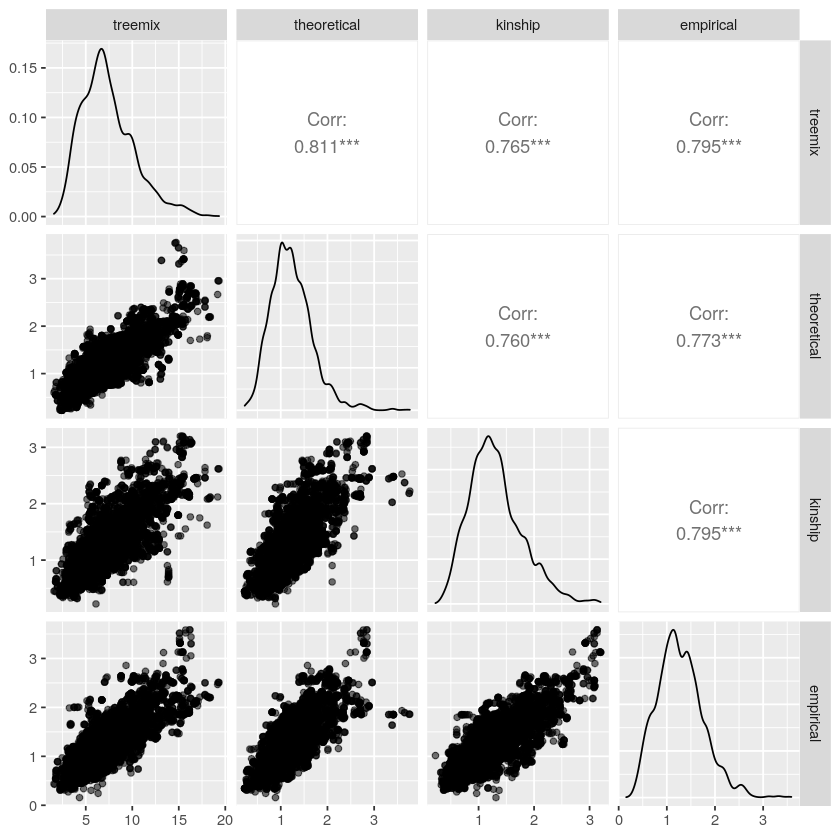

In [51]:
hapWIDE %>% filter(m==0.3&s==0.1&replicate==11) %>% ggpairs(columns=6:9, mapping=ggplot2::aes(alpha=0.01))

## p-value distributions

p-values distributions for chi-squared rescaled values were pretty weird, with a high bar close to one. I want to revisit the code and see what's that about.

In [128]:
# function for computing scaled values
qReg <- function(x, probs = seq(0,1-0.01,0.01),df){
    # Compute empirical quantiles
    eq <- quantile(x, probs=probs)
    # Compute theoretical quantiles
    tq  <- qchisq(probs, df=df ) 
    # Fit a robust linear model
    fit  <- MASS::rlm(tq~eq)
    # Get coefficients
    b <- fit$coefficients[1]
    a <- fit$coefficients[2]
    # Return scaled values
    y_hat <- x*a + b
    return(y_hat)
}

In [129]:
a <- hapflk %>%
    filter(s==0.1,m==0.3) %>%
    group_by(replicate, covariance) %>%
    rename(unscaled="hapflk") %>%
    mutate(scaled=qReg(unscaled, df = hapflk_df) ) %>%
    pivot_longer(cols = c("unscaled", "scaled"),
                 names_to = "scaling",
                 values_to = "hapflk" ) %>%
    group_by(replicate,covariance,scaling) %>%
    mutate(pval = 1- pchisq(hapflk, df = hapflk_df ) ) %>%
    mutate(qval = p.adjust(pval, method = "fdr" ) ) %>%
    ungroup()

ERROR: Error: Failed to create output due to bad names.
* Choose another strategy with `names_repair`


In [ ]:
a %>% filter(scaling=="scaled") %>% 
ggplot() +
geom_histogram(aes(x=pval,fill=covariance),color="black")+
scale_fill_manual(values = colors) +
theme_light() +
facet_wrap(~covariance,scales="free",ncol=2)

El problema era que no habia filtrado las categorias `scaled` y `unscaled`.

In [ ]:
head(a)

In [ ]:
a %>%
filter(scaling=="scaled") %>%
ggplot() +
geom_point(aes(x=pos,y=-log10(qval), color=covariance))+
scale_color_manual(values = colors) +
theme_light() +
facet_wrap(~covariance,scales="free",ncol=1)

## Frequency at selection

In [ ]:
mcoef <- 0
sgen <- ??
frequencies %>%
    filter(m==mcoef&s==0.1) %>%
    filter(generation==sgen) %>%
    ggplot(aes(x=freq, fill=pop)) +
    geom_histogram(binwidth = 0.01) +
    theme_light() + 
    facet_wrap(~pop, scales="free_y", ncol =1)+
    scale_fill_manual(values=popcolors)